In [2]:
import torch
from torchvision import datasets

In [15]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from utils import label2one_hot, plot_report
from generate_data import generate_data, generate_grid_data
from modules import Dropout
from modules import Linear, Sequential
import modules
from modules.losses import LossMSE, LossCrossEntropy
from optimizers import SGD
from load_data import load_data
from networks import default_net

In [8]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=0)
_, train_target_mse, _, test_target_mse = load_data(one_hot_labels = True, normalize = True, flatten = True, data_dir = None, cifar = False, full = True, tiny = False, val=-1)

* Using MNIST
** Use 60000 train and 10000 test samples
* Using MNIST
** Use 60000 train and 10000 test samples


In [9]:
train_input.size()

torch.Size([60000, 784])

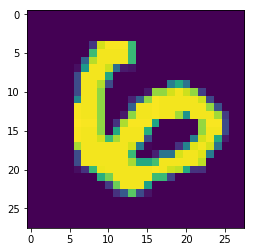

In [10]:
fig = plt.figure()
plt.imshow(train_input[9000,:].view(28,28))
plt.show()

In [11]:
train_target

tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  1.,  0.]])

In [12]:
train_target_mse

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [ 1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1.,  1., -1.]])

In [16]:
model1, train1 = default_net(train_input, train_target, num_of_hidden_layers=0, loss='ce', num_of_neurons=(784, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test1 = model1.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_Softmax 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.678770661354065
key: train_acc -- value: 0.5052000284194946
key: val_loss -- value: 1.681015133857727
key: val_acc -- value: 0.5072333216667175


  1%|▊                                                                                 | 1/100 [00:00<00:18,  5.25it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.9831315875053406
key: train_acc -- value: 0.6650999784469604
key: val_loss -- value: 0.9930968284606934
key: val_acc -- value: 0.6629999876022339


  2%|█▋                                                                                | 2/100 [00:00<00:19,  5.11it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6735314726829529
key: train_acc -- value: 0.7741000056266785
key: val_loss -- value: 0.6777700781822205
key: val_acc -- value: 0.7719666957855225


  3%|██▍                                                                               | 3/100 [00:00<00:18,  5.11it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6312116384506226
key: train_acc -- value: 0.8026000261306763
key: val_loss -- value: 0.6343586444854736
key: val_acc -- value: 0.8012999892234802


  4%|███▎                                                                              | 4/100 [00:00<00:18,  5.23it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5855464935302734
key: train_acc -- value: 0.8273000121116638
key: val_loss -- value: 0.5908458232879639
key: val_acc -- value: 0.8258000016212463


  5%|████                                                                              | 5/100 [00:00<00:17,  5.30it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5540724396705627
key: train_acc -- value: 0.8447333574295044
key: val_loss -- value: 0.5613119602203369
key: val_acc -- value: 0.8454999923706055


  6%|████▉                                                                             | 6/100 [00:01<00:17,  5.31it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5526182651519775
key: train_acc -- value: 0.8517666459083557
key: val_loss -- value: 0.5607208609580994
key: val_acc -- value: 0.8510666489601135


  7%|█████▋                                                                            | 7/100 [00:01<00:17,  5.26it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5552881956100464
key: train_acc -- value: 0.8578333258628845
key: val_loss -- value: 0.5620772242546082
key: val_acc -- value: 0.857699990272522


  8%|██████▌                                                                           | 8/100 [00:01<00:17,  5.30it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5464367270469666
key: train_acc -- value: 0.8674333095550537
key: val_loss -- value: 0.5510584712028503
key: val_acc -- value: 0.8675666451454163


  9%|███████▍                                                                          | 9/100 [00:01<00:17,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5422792434692383
key: train_acc -- value: 0.8750333189964294
key: val_loss -- value: 0.5458148717880249
key: val_acc -- value: 0.874666690826416


 10%|████████                                                                         | 10/100 [00:01<00:16,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.551020622253418
key: train_acc -- value: 0.8761000037193298
key: val_loss -- value: 0.5544815063476562
key: val_acc -- value: 0.8767333626747131


 11%|████████▉                                                                        | 11/100 [00:02<00:16,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5556023716926575
key: train_acc -- value: 0.8765333294868469
key: val_loss -- value: 0.5596089959144592
key: val_acc -- value: 0.876800000667572


 12%|█████████▋                                                                       | 12/100 [00:02<00:16,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5499366521835327
key: train_acc -- value: 0.8797333240509033
key: val_loss -- value: 0.554369330406189
key: val_acc -- value: 0.880299985408783


 13%|██████████▌                                                                      | 13/100 [00:02<00:16,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5442038774490356
key: train_acc -- value: 0.8813333511352539
key: val_loss -- value: 0.5491093993186951
key: val_acc -- value: 0.8824999928474426


 14%|███████████▎                                                                     | 14/100 [00:02<00:15,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5408329367637634
key: train_acc -- value: 0.8822000026702881
key: val_loss -- value: 0.5464431643486023
key: val_acc -- value: 0.8836333155632019


 15%|████████████▏                                                                    | 15/100 [00:02<00:15,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5326562523841858
key: train_acc -- value: 0.8836333155632019
key: val_loss -- value: 0.539195716381073
key: val_acc -- value: 0.8865333199501038


 16%|████████████▉                                                                    | 16/100 [00:02<00:15,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5188145041465759
key: train_acc -- value: 0.8870999813079834
key: val_loss -- value: 0.5264729261398315
key: val_acc -- value: 0.8892999887466431


 17%|█████████████▊                                                                   | 17/100 [00:03<00:15,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.50723797082901
key: train_acc -- value: 0.8903999924659729
key: val_loss -- value: 0.5163048505783081
key: val_acc -- value: 0.8913999795913696


 18%|██████████████▌                                                                  | 18/100 [00:03<00:15,  5.41it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.502156138420105
key: train_acc -- value: 0.892133355140686
key: val_loss -- value: 0.5128769278526306
key: val_acc -- value: 0.8923666477203369


 19%|███████████████▍                                                                 | 19/100 [00:03<00:14,  5.41it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.49824610352516174
key: train_acc -- value: 0.893666684627533
key: val_loss -- value: 0.5106061100959778
key: val_acc -- value: 0.8922333121299744


 20%|████████████████▏                                                                | 20/100 [00:03<00:14,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.48932385444641113
key: train_acc -- value: 0.8949333429336548
key: val_loss -- value: 0.5030839443206787
key: val_acc -- value: 0.8931999802589417


 21%|█████████████████                                                                | 21/100 [00:03<00:14,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.47727951407432556
key: train_acc -- value: 0.8970000147819519
key: val_loss -- value: 0.49225008487701416
key: val_acc -- value: 0.8950666785240173


 22%|█████████████████▊                                                               | 22/100 [00:04<00:14,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.46776923537254333
key: train_acc -- value: 0.8978999853134155
key: val_loss -- value: 0.4839654564857483
key: val_acc -- value: 0.8966333270072937


 23%|██████████████████▋                                                              | 23/100 [00:04<00:14,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4615075886249542
key: train_acc -- value: 0.8992000222206116
key: val_loss -- value: 0.47905290126800537
key: val_acc -- value: 0.8967000246047974


 24%|███████████████████▍                                                             | 24/100 [00:04<00:14,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4544869661331177
key: train_acc -- value: 0.8991333246231079
key: val_loss -- value: 0.47348442673683167
key: val_acc -- value: 0.8966000080108643


 25%|████████████████████▎                                                            | 25/100 [00:04<00:13,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.44492363929748535
key: train_acc -- value: 0.9008333086967468
key: val_loss -- value: 0.4652227759361267
key: val_acc -- value: 0.8979666829109192


 26%|█████████████████████                                                            | 26/100 [00:04<00:13,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.43518757820129395
key: train_acc -- value: 0.9023333191871643
key: val_loss -- value: 0.4566572606563568
key: val_acc -- value: 0.8994666934013367


 27%|█████████████████████▊                                                           | 27/100 [00:05<00:13,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.42729175090789795
key: train_acc -- value: 0.902400016784668
key: val_loss -- value: 0.44973838329315186
key: val_acc -- value: 0.9002666473388672


 28%|██████████████████████▋                                                          | 28/100 [00:05<00:13,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.41988876461982727
key: train_acc -- value: 0.9035666584968567
key: val_loss -- value: 0.44312503933906555
key: val_acc -- value: 0.901366651058197


 29%|███████████████████████▍                                                         | 29/100 [00:05<00:13,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4114995300769806
key: train_acc -- value: 0.9046666622161865
key: val_loss -- value: 0.4354149401187897
key: val_acc -- value: 0.9023666381835938


 30%|████████████████████████▎                                                        | 30/100 [00:05<00:12,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4033399820327759
key: train_acc -- value: 0.906000018119812
key: val_loss -- value: 0.42799586057662964
key: val_acc -- value: 0.9033666849136353


 31%|█████████████████████████                                                        | 31/100 [00:05<00:12,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3968488574028015
key: train_acc -- value: 0.9071000218391418
key: val_loss -- value: 0.4223611056804657
key: val_acc -- value: 0.9039000272750854


 32%|█████████████████████████▉                                                       | 32/100 [00:05<00:12,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3909660279750824
key: train_acc -- value: 0.9078999757766724
key: val_loss -- value: 0.4173615276813507
key: val_acc -- value: 0.90420001745224


 33%|██████████████████████████▋                                                      | 33/100 [00:06<00:12,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.38408178091049194
key: train_acc -- value: 0.9082666635513306
key: val_loss -- value: 0.41134020686149597
key: val_acc -- value: 0.9047999978065491


 34%|███████████████████████████▌                                                     | 34/100 [00:06<00:12,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3767816126346588
key: train_acc -- value: 0.909166693687439
key: val_loss -- value: 0.4048802852630615
key: val_acc -- value: 0.906166672706604


 35%|████████████████████████████▎                                                    | 35/100 [00:06<00:12,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3704075217247009
key: train_acc -- value: 0.9107000231742859
key: val_loss -- value: 0.39937323331832886
key: val_acc -- value: 0.9067000150680542


 36%|█████████████████████████████▏                                                   | 36/100 [00:06<00:11,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3647012412548065
key: train_acc -- value: 0.9108666777610779
key: val_loss -- value: 0.394560843706131
key: val_acc -- value: 0.9070666432380676


 37%|█████████████████████████████▉                                                   | 37/100 [00:06<00:11,  5.41it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3589246869087219
key: train_acc -- value: 0.9117000102996826
key: val_loss -- value: 0.3896196186542511
key: val_acc -- value: 0.907966673374176


 38%|██████████████████████████████▊                                                  | 38/100 [00:07<00:11,  5.41it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.35353460907936096
key: train_acc -- value: 0.9123333096504211
key: val_loss -- value: 0.385010689496994
key: val_acc -- value: 0.9082333445549011


 39%|███████████████████████████████▌                                                 | 39/100 [00:07<00:11,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3487958610057831
key: train_acc -- value: 0.9126666784286499
key: val_loss -- value: 0.3810012936592102
key: val_acc -- value: 0.9085000157356262


 40%|████████████████████████████████▍                                                | 40/100 [00:07<00:11,  5.40it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3438244163990021
key: train_acc -- value: 0.9134666919708252
key: val_loss -- value: 0.3767407536506653
key: val_acc -- value: 0.9086999893188477


 41%|█████████████████████████████████▏                                               | 41/100 [00:07<00:10,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.33850064873695374
key: train_acc -- value: 0.9143000245094299
key: val_loss -- value: 0.3720546364784241
key: val_acc -- value: 0.909500002861023


 42%|██████████████████████████████████                                               | 42/100 [00:07<00:10,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.33392301201820374
key: train_acc -- value: 0.9149333238601685
key: val_loss -- value: 0.36803603172302246
key: val_acc -- value: 0.910099983215332


 43%|██████████████████████████████████▊                                              | 43/100 [00:07<00:10,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3302787244319916
key: train_acc -- value: 0.9154999852180481
key: val_loss -- value: 0.3648628294467926
key: val_acc -- value: 0.9110333323478699


 44%|███████████████████████████████████▋                                             | 44/100 [00:08<00:10,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3265514075756073
key: train_acc -- value: 0.9161333441734314
key: val_loss -- value: 0.3615588843822479
key: val_acc -- value: 0.9117333292961121


 45%|████████████████████████████████████▍                                            | 45/100 [00:08<00:10,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.32260093092918396
key: train_acc -- value: 0.9168000221252441
key: val_loss -- value: 0.35799840092658997
key: val_acc -- value: 0.911899983882904


 46%|█████████████████████████████████████▎                                           | 46/100 [00:08<00:10,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.31911298632621765
key: train_acc -- value: 0.9172666668891907
key: val_loss -- value: 0.3549303710460663
key: val_acc -- value: 0.9120000004768372


 47%|██████████████████████████████████████                                           | 47/100 [00:08<00:09,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.31604042649269104
key: train_acc -- value: 0.9172000288963318
key: val_loss -- value: 0.3523077070713043
key: val_acc -- value: 0.9126666784286499


 48%|██████████████████████████████████████▉                                          | 48/100 [00:08<00:09,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3128862679004669
key: train_acc -- value: 0.9180999994277954
key: val_loss -- value: 0.34961560368537903
key: val_acc -- value: 0.9126666784286499


 49%|███████████████████████████████████████▋                                         | 49/100 [00:09<00:09,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3098200559616089
key: train_acc -- value: 0.918833315372467
key: val_loss -- value: 0.34700044989585876
key: val_acc -- value: 0.913100004196167


 50%|████████████████████████████████████████▌                                        | 50/100 [00:09<00:09,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.30708178877830505
key: train_acc -- value: 0.9188666939735413
key: val_loss -- value: 0.3447466790676117
key: val_acc -- value: 0.9136333465576172


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:09<00:09,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.30443423986434937
key: train_acc -- value: 0.9188666939735413
key: val_loss -- value: 0.34261980652809143
key: val_acc -- value: 0.9143000245094299


 52%|██████████████████████████████████████████                                       | 52/100 [00:09<00:08,  5.39it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.30183401703834534
key: train_acc -- value: 0.9190666675567627
key: val_loss -- value: 0.3405314087867737
key: val_acc -- value: 0.9141333103179932


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:09<00:08,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2995060086250305
key: train_acc -- value: 0.9194333553314209
key: val_loss -- value: 0.33864423632621765
key: val_acc -- value: 0.914733350276947


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:10<00:08,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.29737046360969543
key: train_acc -- value: 0.9202666878700256
key: val_loss -- value: 0.3368544280529022
key: val_acc -- value: 0.914900004863739


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:10<00:08,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.29524749517440796
key: train_acc -- value: 0.9206333160400391
key: val_loss -- value: 0.334985613822937
key: val_acc -- value: 0.9153666496276855


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:10<00:08,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2931690812110901
key: train_acc -- value: 0.9203333258628845
key: val_loss -- value: 0.3331308960914612
key: val_acc -- value: 0.9153666496276855


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:10<00:08,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.29117637872695923
key: train_acc -- value: 0.9208333492279053
key: val_loss -- value: 0.3313603401184082
key: val_acc -- value: 0.9158999919891357


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:10<00:07,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.28925925493240356
key: train_acc -- value: 0.9214666485786438
key: val_loss -- value: 0.32970133423805237
key: val_acc -- value: 0.9155666828155518


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:10<00:07,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.28750571608543396
key: train_acc -- value: 0.9218666553497314
key: val_loss -- value: 0.32821446657180786
key: val_acc -- value: 0.9156333208084106


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:11<00:07,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2858811914920807
key: train_acc -- value: 0.9222000241279602
key: val_loss -- value: 0.326822429895401
key: val_acc -- value: 0.9157333374023438


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:11<00:07,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2842480540275574
key: train_acc -- value: 0.9225000143051147
key: val_loss -- value: 0.3253512680530548
key: val_acc -- value: 0.9157999753952026


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:11<00:07,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.28265827894210815
key: train_acc -- value: 0.9228000044822693
key: val_loss -- value: 0.3238697648048401
key: val_acc -- value: 0.9166666865348816


 63%|███████████████████████████████████████████████████                              | 63/100 [00:11<00:06,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2812178134918213
key: train_acc -- value: 0.9233333468437195
key: val_loss -- value: 0.32252347469329834
key: val_acc -- value: 0.9168999791145325


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:11<00:06,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27984312176704407
key: train_acc -- value: 0.9235000014305115
key: val_loss -- value: 0.3212583661079407
key: val_acc -- value: 0.9172666668891907


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:12<00:06,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2784768044948578
key: train_acc -- value: 0.9240666627883911
key: val_loss -- value: 0.32002878189086914
key: val_acc -- value: 0.9176999926567078


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:12<00:06,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2771807909011841
key: train_acc -- value: 0.9241666793823242
key: val_loss -- value: 0.3188752830028534
key: val_acc -- value: 0.9177333116531372


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:12<00:06,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27594804763793945
key: train_acc -- value: 0.9244333505630493
key: val_loss -- value: 0.3177535831928253
key: val_acc -- value: 0.9178333282470703


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:12<00:05,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27474260330200195
key: train_acc -- value: 0.9245333075523376
key: val_loss -- value: 0.31662166118621826
key: val_acc -- value: 0.9181333184242249


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:12<00:05,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27360865473747253
key: train_acc -- value: 0.9245333075523376
key: val_loss -- value: 0.3155292272567749
key: val_acc -- value: 0.9185000061988831


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:13<00:05,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.272535502910614
key: train_acc -- value: 0.9245333075523376
key: val_loss -- value: 0.3145008981227875
key: val_acc -- value: 0.9185000061988831


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:13<00:05,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27148115634918213
key: train_acc -- value: 0.9247333407402039
key: val_loss -- value: 0.31351256370544434
key: val_acc -- value: 0.91839998960495


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:13<00:05,  5.38it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.270466685295105
key: train_acc -- value: 0.9249666929244995
key: val_loss -- value: 0.3126004934310913
key: val_acc -- value: 0.9187333583831787


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:13<00:05,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2695116698741913
key: train_acc -- value: 0.9252333045005798
key: val_loss -- value: 0.3117646276950836
key: val_acc -- value: 0.9189333319664001


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:13<00:04,  5.37it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2685876190662384
key: train_acc -- value: 0.9252333045005798
key: val_loss -- value: 0.31096306443214417
key: val_acc -- value: 0.9191333055496216


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:13<00:04,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2677021920681
key: train_acc -- value: 0.9253000020980835
key: val_loss -- value: 0.3101918399333954
key: val_acc -- value: 0.9193666577339172


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:14<00:04,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2668551206588745
key: train_acc -- value: 0.9254999756813049
key: val_loss -- value: 0.30944791436195374
key: val_acc -- value: 0.9195333123207092


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:14<00:04,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2660166919231415
key: train_acc -- value: 0.9255666732788086
key: val_loss -- value: 0.3087136447429657
key: val_acc -- value: 0.9196000099182129


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:14<00:04,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2652093470096588
key: train_acc -- value: 0.9257333278656006
key: val_loss -- value: 0.3080117404460907
key: val_acc -- value: 0.9193666577339172


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:14<00:03,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2644529938697815
key: train_acc -- value: 0.9261333346366882
key: val_loss -- value: 0.307364821434021
key: val_acc -- value: 0.9194333553314209


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:14<00:03,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2637174427509308
key: train_acc -- value: 0.9264000058174133
key: val_loss -- value: 0.3067333996295929
key: val_acc -- value: 0.9196000099182129


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:15<00:03,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2629960775375366
key: train_acc -- value: 0.9264000058174133
key: val_loss -- value: 0.30611327290534973
key: val_acc -- value: 0.919700026512146


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:15<00:03,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2623139023780823
key: train_acc -- value: 0.9264000058174133
key: val_loss -- value: 0.30553364753723145
key: val_acc -- value: 0.919700026512146


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:15<00:03,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2616623342037201
key: train_acc -- value: 0.9264333248138428
key: val_loss -- value: 0.3049895763397217
key: val_acc -- value: 0.9196333289146423


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:15<00:02,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.26102393865585327
key: train_acc -- value: 0.9268333315849304
key: val_loss -- value: 0.3044670820236206
key: val_acc -- value: 0.9197999835014343


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:15<00:02,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.26040852069854736
key: train_acc -- value: 0.9272000193595886
key: val_loss -- value: 0.3039740025997162
key: val_acc -- value: 0.9199000000953674


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:16<00:02,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25981587171554565
key: train_acc -- value: 0.9273666739463806
key: val_loss -- value: 0.30350396037101746
key: val_acc -- value: 0.9199666380882263


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:16<00:02,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25923487544059753
key: train_acc -- value: 0.9274333119392395
key: val_loss -- value: 0.3030531704425812
key: val_acc -- value: 0.919866681098938


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:16<00:02,  5.34it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2586757242679596
key: train_acc -- value: 0.9275000095367432
key: val_loss -- value: 0.30262425541877747
key: val_acc -- value: 0.9199666380882263


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:16<00:02,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2581426203250885
key: train_acc -- value: 0.9274333119392395
key: val_loss -- value: 0.30222928524017334
key: val_acc -- value: 0.9200666546821594


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:16<00:01,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2576234042644501
key: train_acc -- value: 0.9275333285331726
key: val_loss -- value: 0.3018516004085541
key: val_acc -- value: 0.9200000166893005


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:17<00:01,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2571166157722473
key: train_acc -- value: 0.9277666807174683
key: val_loss -- value: 0.3014845848083496
key: val_acc -- value: 0.9199000000953674


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:17<00:01,  5.35it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25662893056869507
key: train_acc -- value: 0.9278666377067566
key: val_loss -- value: 0.3011249005794525
key: val_acc -- value: 0.9197999835014343


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:17<00:01,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2561541199684143
key: train_acc -- value: 0.9279999732971191
key: val_loss -- value: 0.3007732033729553
key: val_acc -- value: 0.919700026512146


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:17<00:01,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2556944191455841
key: train_acc -- value: 0.9281333088874817
key: val_loss -- value: 0.30043289065361023
key: val_acc -- value: 0.9197333455085754


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:17<00:00,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.255249559879303
key: train_acc -- value: 0.9280333518981934
key: val_loss -- value: 0.30011212825775146
key: val_acc -- value: 0.9199333190917969


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:17<00:00,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25481563806533813
key: train_acc -- value: 0.9281333088874817
key: val_loss -- value: 0.2998086214065552
key: val_acc -- value: 0.9200000166893005


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:18<00:00,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.25439295172691345
key: train_acc -- value: 0.9282333254814148
key: val_loss -- value: 0.2995206415653229
key: val_acc -- value: 0.9200999736785889


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:18<00:00,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2539852559566498
key: train_acc -- value: 0.9282666444778442
key: val_loss -- value: 0.2992391288280487
key: val_acc -- value: 0.9203333258628845


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:18<00:00,  5.36it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2535879909992218
key: train_acc -- value: 0.9283999800682068
key: val_loss -- value: 0.2989588975906372
key: val_acc -- value: 0.9203333258628845


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.36it/s]


torch.Size([10000, 10])  --  torch.Size([10000, 10])


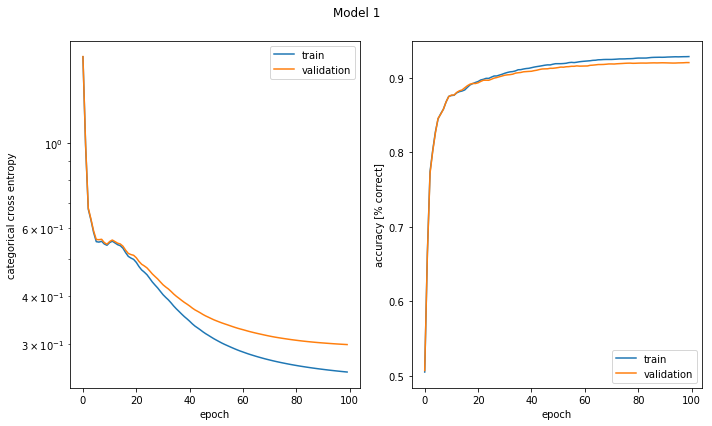

In [18]:
plot_report(train1, title="Model 1")

In [19]:
test1

(tensor(0.9190), 0.28673243522644043, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [24]:
model2, train2 = default_net(train_input, train_target, num_of_hidden_layers=1, loss='ce', num_of_neurons=(784, 500, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test2 = model2.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_Softmax 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.902579426765442
key: train_acc -- value: 0.5412333607673645
key: val_loss -- value: 1.8969204425811768
key: val_acc -- value: 0.5471000075340271


  1%|▊                                                                                 | 1/100 [00:01<03:12,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.3541932106018066
key: train_acc -- value: 0.7163666486740112
key: val_loss -- value: 1.347365140914917
key: val_acc -- value: 0.7204333543777466


  2%|█▋                                                                                | 2/100 [00:03<03:10,  1.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.904732346534729
key: train_acc -- value: 0.7864000201225281
key: val_loss -- value: 0.9018104076385498
key: val_acc -- value: 0.7876999974250793


  3%|██▍                                                                               | 3/100 [00:05<03:09,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6653465628623962
key: train_acc -- value: 0.8197000026702881
key: val_loss -- value: 0.6691465377807617
key: val_acc -- value: 0.8199333548545837


  4%|███▎                                                                              | 4/100 [00:07<03:08,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5501632690429688
key: train_acc -- value: 0.8371666669845581
key: val_loss -- value: 0.5576260685920715
key: val_acc -- value: 0.8355666399002075


  5%|████                                                                              | 5/100 [00:09<03:06,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4957412779331207
key: train_acc -- value: 0.8448666930198669
key: val_loss -- value: 0.5040721893310547
key: val_acc -- value: 0.8428000211715698


  6%|████▉                                                                             | 6/100 [00:11<03:04,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.464396595954895
key: train_acc -- value: 0.8568333387374878
key: val_loss -- value: 0.4771905839443207
key: val_acc -- value: 0.852566659450531


  7%|█████▋                                                                            | 7/100 [00:13<03:01,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.45744770765304565
key: train_acc -- value: 0.8642666935920715
key: val_loss -- value: 0.47414669394493103
key: val_acc -- value: 0.862333357334137


  8%|██████▌                                                                           | 8/100 [00:15<02:59,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4402214288711548
key: train_acc -- value: 0.8771666884422302
key: val_loss -- value: 0.45811572670936584
key: val_acc -- value: 0.8715333342552185


  9%|███████▍                                                                          | 9/100 [00:17<02:57,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.43480929732322693
key: train_acc -- value: 0.8803666830062866
key: val_loss -- value: 0.4537394940853119
key: val_acc -- value: 0.8768666386604309


 10%|████████                                                                         | 10/100 [00:19<02:54,  1.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.42805999517440796
key: train_acc -- value: 0.8845666646957397
key: val_loss -- value: 0.451914519071579
key: val_acc -- value: 0.8799999952316284


 11%|████████▉                                                                        | 11/100 [00:21<02:52,  1.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4249911606311798
key: train_acc -- value: 0.8877666592597961
key: val_loss -- value: 0.4532919228076935
key: val_acc -- value: 0.8843333125114441


 12%|█████████▋                                                                       | 12/100 [00:23<02:49,  1.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4128032624721527
key: train_acc -- value: 0.8924000263214111
key: val_loss -- value: 0.44102969765663147
key: val_acc -- value: 0.8891333341598511


 13%|██████████▌                                                                      | 13/100 [00:24<02:47,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4021405279636383
key: train_acc -- value: 0.8960666656494141
key: val_loss -- value: 0.43050092458724976
key: val_acc -- value: 0.8929333090782166


 14%|███████████▎                                                                     | 14/100 [00:26<02:44,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3909163177013397
key: train_acc -- value: 0.899066686630249
key: val_loss -- value: 0.4223234951496124
key: val_acc -- value: 0.8940666913986206


 15%|████████████▏                                                                    | 15/100 [00:28<02:42,  1.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.37621864676475525
key: train_acc -- value: 0.9019666910171509
key: val_loss -- value: 0.41013967990875244
key: val_acc -- value: 0.8963000178337097


 16%|████████████▉                                                                    | 16/100 [00:30<02:40,  1.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.36347779631614685
key: train_acc -- value: 0.9056000113487244
key: val_loss -- value: 0.39907512068748474
key: val_acc -- value: 0.8998000025749207


 17%|█████████████▊                                                                   | 17/100 [00:32<02:38,  1.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3469249904155731
key: train_acc -- value: 0.9087666869163513
key: val_loss -- value: 0.384671151638031
key: val_acc -- value: 0.9031000137329102


 18%|██████████████▌                                                                  | 18/100 [00:34<02:36,  1.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.33403196930885315
key: train_acc -- value: 0.9097333550453186
key: val_loss -- value: 0.3742554783821106
key: val_acc -- value: 0.904699981212616


 19%|███████████████▍                                                                 | 19/100 [00:36<02:35,  1.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.31753313541412354
key: train_acc -- value: 0.9125333428382874
key: val_loss -- value: 0.3587765395641327
key: val_acc -- value: 0.9083333611488342


 20%|████████████████▏                                                                | 20/100 [00:38<02:33,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3078339695930481
key: train_acc -- value: 0.9150999784469604
key: val_loss -- value: 0.3494085371494293
key: val_acc -- value: 0.909333348274231


 21%|█████████████████                                                                | 21/100 [00:40<02:31,  1.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.29194915294647217
key: train_acc -- value: 0.9176666736602783
key: val_loss -- value: 0.3346579670906067
key: val_acc -- value: 0.9115333557128906


 22%|█████████████████▊                                                               | 22/100 [00:42<02:31,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2822848856449127
key: train_acc -- value: 0.9185666441917419
key: val_loss -- value: 0.32584133744239807
key: val_acc -- value: 0.9131666421890259


 23%|██████████████████▋                                                              | 23/100 [00:44<02:30,  1.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.27007460594177246
key: train_acc -- value: 0.9224666953086853
key: val_loss -- value: 0.31263265013694763
key: val_acc -- value: 0.9151999950408936


 24%|███████████████████▍                                                             | 24/100 [00:47<02:29,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.26365721225738525
key: train_acc -- value: 0.9240000247955322
key: val_loss -- value: 0.3053801953792572
key: val_acc -- value: 0.9158666729927063


 25%|████████████████████▎                                                            | 25/100 [00:49<02:27,  1.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2516680359840393
key: train_acc -- value: 0.9262333512306213
key: val_loss -- value: 0.29399871826171875
key: val_acc -- value: 0.9182666540145874


 26%|█████████████████████                                                            | 26/100 [00:51<02:25,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2457803338766098
key: train_acc -- value: 0.9274333119392395
key: val_loss -- value: 0.2881889045238495
key: val_acc -- value: 0.9199333190917969


 27%|█████████████████████▊                                                           | 27/100 [00:53<02:23,  1.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.23791462182998657
key: train_acc -- value: 0.9314333200454712
key: val_loss -- value: 0.27955836057662964
key: val_acc -- value: 0.9217000007629395


 28%|██████████████████████▋                                                          | 28/100 [00:55<02:22,  1.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.23050792515277863
key: train_acc -- value: 0.934066653251648
key: val_loss -- value: 0.27198079228401184
key: val_acc -- value: 0.9242666959762573


 29%|███████████████████████▍                                                         | 29/100 [00:57<02:20,  1.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.225651353597641
key: train_acc -- value: 0.9354333281517029
key: val_loss -- value: 0.2675696015357971
key: val_acc -- value: 0.9253333210945129


 30%|████████████████████████▎                                                        | 30/100 [00:59<02:18,  1.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2188543677330017
key: train_acc -- value: 0.9383666515350342
key: val_loss -- value: 0.2606174349784851
key: val_acc -- value: 0.9265000224113464


 31%|█████████████████████████                                                        | 31/100 [01:01<02:17,  1.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.21475555002689362
key: train_acc -- value: 0.9393333196640015
key: val_loss -- value: 0.2560455799102783
key: val_acc -- value: 0.9282666444778442


 32%|█████████████████████████▉                                                       | 32/100 [01:03<02:15,  1.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20879274606704712
key: train_acc -- value: 0.9407333135604858
key: val_loss -- value: 0.2498539239168167
key: val_acc -- value: 0.9292666912078857


 33%|██████████████████████████▋                                                      | 33/100 [01:05<02:13,  1.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20454713702201843
key: train_acc -- value: 0.941433310508728
key: val_loss -- value: 0.24566338956356049
key: val_acc -- value: 0.9305333495140076


 34%|███████████████████████████▌                                                     | 34/100 [01:07<02:11,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19936159253120422
key: train_acc -- value: 0.9434000253677368
key: val_loss -- value: 0.24061192572116852
key: val_acc -- value: 0.9315999746322632


 35%|████████████████████████████▎                                                    | 35/100 [01:09<02:09,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19483254849910736
key: train_acc -- value: 0.9447333216667175
key: val_loss -- value: 0.23630180954933167
key: val_acc -- value: 0.9332666397094727


 36%|█████████████████████████████▏                                                   | 36/100 [01:12<02:08,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1903572827577591
key: train_acc -- value: 0.9462000131607056
key: val_loss -- value: 0.23187826573848724
key: val_acc -- value: 0.9351666569709778


 37%|█████████████████████████████▉                                                   | 37/100 [01:14<02:06,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.18606998026371002
key: train_acc -- value: 0.9470999836921692
key: val_loss -- value: 0.22719433903694153
key: val_acc -- value: 0.9361000061035156


 38%|██████████████████████████████▊                                                  | 38/100 [01:16<02:04,  2.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1823752224445343
key: train_acc -- value: 0.9477333426475525
key: val_loss -- value: 0.22323130071163177
key: val_acc -- value: 0.9365333318710327


 39%|███████████████████████████████▌                                                 | 39/100 [01:18<02:02,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17812348902225494
key: train_acc -- value: 0.949566662311554
key: val_loss -- value: 0.21921883523464203
key: val_acc -- value: 0.9382666945457458


 40%|████████████████████████████████▍                                                | 40/100 [01:20<02:00,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17486685514450073
key: train_acc -- value: 0.9506666660308838
key: val_loss -- value: 0.21642348170280457
key: val_acc -- value: 0.9395333528518677


 41%|█████████████████████████████████▏                                               | 41/100 [01:22<01:58,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17134572565555573
key: train_acc -- value: 0.9519333243370056
key: val_loss -- value: 0.21298012137413025
key: val_acc -- value: 0.9399999976158142


 42%|██████████████████████████████████                                               | 42/100 [01:24<01:56,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1679399460554123
key: train_acc -- value: 0.9527000188827515
key: val_loss -- value: 0.2093721181154251
key: val_acc -- value: 0.9406999945640564


 43%|██████████████████████████████████▊                                              | 43/100 [01:26<01:54,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16462641954421997
key: train_acc -- value: 0.95333331823349
key: val_loss -- value: 0.20595195889472961
key: val_acc -- value: 0.9421333074569702


 44%|███████████████████████████████████▋                                             | 44/100 [01:28<01:52,  2.01s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16181392967700958
key: train_acc -- value: 0.9538000226020813
key: val_loss -- value: 0.20324313640594482
key: val_acc -- value: 0.9430666565895081


 45%|████████████████████████████████████▍                                            | 45/100 [01:30<01:50,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1586635708808899
key: train_acc -- value: 0.9548333287239075
key: val_loss -- value: 0.2003054916858673
key: val_acc -- value: 0.9435999989509583


 46%|█████████████████████████████████████▎                                           | 46/100 [01:32<01:48,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15587309002876282
key: train_acc -- value: 0.9562333226203918
key: val_loss -- value: 0.1977924406528473
key: val_acc -- value: 0.9437666535377502


 47%|██████████████████████████████████████                                           | 47/100 [01:34<01:46,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15316861867904663
key: train_acc -- value: 0.9569666385650635
key: val_loss -- value: 0.19538353383541107
key: val_acc -- value: 0.9443666934967041


 48%|██████████████████████████████████████▉                                          | 48/100 [01:36<01:45,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15058577060699463
key: train_acc -- value: 0.957099974155426
key: val_loss -- value: 0.19298963248729706
key: val_acc -- value: 0.9453999996185303


 49%|███████████████████████████████████████▋                                         | 49/100 [01:39<01:43,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14799648523330688
key: train_acc -- value: 0.9577999711036682
key: val_loss -- value: 0.1904391050338745
key: val_acc -- value: 0.945900022983551


 50%|████████████████████████████████████████▌                                        | 50/100 [01:41<01:41,  2.02s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14560449123382568
key: train_acc -- value: 0.9585333466529846
key: val_loss -- value: 0.18812885880470276
key: val_acc -- value: 0.9468333125114441


 51%|█████████████████████████████████████████▎                                       | 51/100 [01:43<01:39,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14324139058589935
key: train_acc -- value: 0.9592999815940857
key: val_loss -- value: 0.18605205416679382
key: val_acc -- value: 0.9470000267028809


 52%|██████████████████████████████████████████                                       | 52/100 [01:45<01:37,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1409282684326172
key: train_acc -- value: 0.9602333307266235
key: val_loss -- value: 0.18416157364845276
key: val_acc -- value: 0.947866678237915


 53%|██████████████████████████████████████████▉                                      | 53/100 [01:47<01:35,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13878421485424042
key: train_acc -- value: 0.9608333110809326
key: val_loss -- value: 0.18236388266086578
key: val_acc -- value: 0.9484000205993652


 54%|███████████████████████████████████████████▋                                     | 54/100 [01:49<01:33,  2.03s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13663052022457123
key: train_acc -- value: 0.9613999724388123
key: val_loss -- value: 0.1803801953792572
key: val_acc -- value: 0.9488666653633118


 55%|████████████████████████████████████████████▌                                    | 55/100 [01:51<01:31,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13463953137397766
key: train_acc -- value: 0.9621333479881287
key: val_loss -- value: 0.1785062849521637
key: val_acc -- value: 0.9491999745368958


 56%|█████████████████████████████████████████████▎                                   | 56/100 [01:54<01:29,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1325926035642624
key: train_acc -- value: 0.9623000025749207
key: val_loss -- value: 0.17666630446910858
key: val_acc -- value: 0.9494333267211914


 57%|██████████████████████████████████████████████▏                                  | 57/100 [01:56<01:27,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1307351142168045
key: train_acc -- value: 0.9628666639328003
key: val_loss -- value: 0.17508447170257568
key: val_acc -- value: 0.9498000144958496


 58%|██████████████████████████████████████████████▉                                  | 58/100 [01:58<01:25,  2.04s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1288219839334488
key: train_acc -- value: 0.963699996471405
key: val_loss -- value: 0.17339953780174255
key: val_acc -- value: 0.9505000114440918


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:01<01:24,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1269771307706833
key: train_acc -- value: 0.9641333222389221
key: val_loss -- value: 0.1717454046010971
key: val_acc -- value: 0.9509999752044678


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:03<01:22,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12518124282360077
key: train_acc -- value: 0.9648333191871643
key: val_loss -- value: 0.17018143832683563
key: val_acc -- value: 0.9514999985694885


 61%|█████████████████████████████████████████████████▍                               | 61/100 [02:05<01:20,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12342844158411026
key: train_acc -- value: 0.96506667137146
key: val_loss -- value: 0.16869990527629852
key: val_acc -- value: 0.9518333077430725


 62%|██████████████████████████████████████████████████▏                              | 62/100 [02:07<01:18,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12172796577215195
key: train_acc -- value: 0.9654333591461182
key: val_loss -- value: 0.1672116369009018
key: val_acc -- value: 0.9521333575248718


 63%|███████████████████████████████████████████████████                              | 63/100 [02:09<01:15,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1200324073433876
key: train_acc -- value: 0.9659000039100647
key: val_loss -- value: 0.16565026342868805
key: val_acc -- value: 0.9524000287055969


 64%|███████████████████████████████████████████████████▊                             | 64/100 [02:11<01:13,  2.05s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11844136565923691
key: train_acc -- value: 0.9662333130836487
key: val_loss -- value: 0.16421003639698029
key: val_acc -- value: 0.9527999758720398


 65%|████████████████████████████████████████████████████▋                            | 65/100 [02:13<01:11,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11684783548116684
key: train_acc -- value: 0.9665666818618774
key: val_loss -- value: 0.16286015510559082
key: val_acc -- value: 0.9530666470527649


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [02:15<01:09,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.115297831594944
key: train_acc -- value: 0.9669666886329651
key: val_loss -- value: 0.16158173978328705
key: val_acc -- value: 0.9532999992370605


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [02:17<01:07,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1137872040271759
key: train_acc -- value: 0.9678666591644287
key: val_loss -- value: 0.1602741926908493
key: val_acc -- value: 0.9536333084106445


 68%|███████████████████████████████████████████████████████                          | 68/100 [02:19<01:05,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11232282221317291
key: train_acc -- value: 0.9689000248908997
key: val_loss -- value: 0.1589658260345459
key: val_acc -- value: 0.9541000127792358


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [02:21<01:03,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11088184267282486
key: train_acc -- value: 0.9694333076477051
key: val_loss -- value: 0.15772105753421783
key: val_acc -- value: 0.9544000029563904


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [02:24<01:01,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10945992171764374
key: train_acc -- value: 0.9696999788284302
key: val_loss -- value: 0.15654802322387695
key: val_acc -- value: 0.9545999765396118


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [02:26<00:59,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10809428989887238
key: train_acc -- value: 0.9700333476066589
key: val_loss -- value: 0.15540307760238647
key: val_acc -- value: 0.9548333287239075


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [02:28<00:57,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10674209892749786
key: train_acc -- value: 0.970633327960968
key: val_loss -- value: 0.15420065820217133
key: val_acc -- value: 0.9550999999046326


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [02:30<00:55,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10542699694633484
key: train_acc -- value: 0.9710333347320557
key: val_loss -- value: 0.1530262678861618
key: val_acc -- value: 0.9554666876792908


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [02:32<00:53,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.104132741689682
key: train_acc -- value: 0.9715666770935059
key: val_loss -- value: 0.15193630754947662
key: val_acc -- value: 0.9558333158493042


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [02:34<00:51,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10287001729011536
key: train_acc -- value: 0.9719333052635193
key: val_loss -- value: 0.15092986822128296
key: val_acc -- value: 0.9560999870300293


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [02:36<00:49,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1016356572508812
key: train_acc -- value: 0.9724666476249695
key: val_loss -- value: 0.14992709457874298
key: val_acc -- value: 0.9567000269889832


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [02:38<00:47,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10041605681180954
key: train_acc -- value: 0.9726666808128357
key: val_loss -- value: 0.1488802582025528
key: val_acc -- value: 0.9570000171661377


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [02:40<00:45,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09923310577869415
key: train_acc -- value: 0.9731333255767822
key: val_loss -- value: 0.14786435663700104
key: val_acc -- value: 0.9572666883468628


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [02:43<00:43,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09806837886571884
key: train_acc -- value: 0.9735000133514404
key: val_loss -- value: 0.1469069868326187
key: val_acc -- value: 0.9578333497047424


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [02:45<00:41,  2.06s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09692691266536713
key: train_acc -- value: 0.9736666679382324
key: val_loss -- value: 0.1460050642490387
key: val_acc -- value: 0.9583666920661926


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [02:47<00:39,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09580802917480469
key: train_acc -- value: 0.9741666913032532
key: val_loss -- value: 0.14511486887931824
key: val_acc -- value: 0.958466649055481


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [02:49<00:37,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09470772743225098
key: train_acc -- value: 0.9745000004768372
key: val_loss -- value: 0.14422257244586945
key: val_acc -- value: 0.9588333368301392


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [02:51<00:35,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09363353997468948
key: train_acc -- value: 0.9748333096504211
key: val_loss -- value: 0.143369659781456
key: val_acc -- value: 0.9589999914169312


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [02:53<00:33,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09257547557353973
key: train_acc -- value: 0.9751666784286499
key: val_loss -- value: 0.1425599902868271
key: val_acc -- value: 0.9592999815940857


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [02:55<00:31,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09153685718774796
key: train_acc -- value: 0.975433349609375
key: val_loss -- value: 0.14177760481834412
key: val_acc -- value: 0.9595000147819519


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [02:57<00:28,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09051938354969025
key: train_acc -- value: 0.975600004196167
key: val_loss -- value: 0.14099198579788208
key: val_acc -- value: 0.9596999883651733


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [03:00<00:26,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08951796591281891
key: train_acc -- value: 0.975933313369751
key: val_loss -- value: 0.14020097255706787
key: val_acc -- value: 0.9599000215530396


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [03:02<00:24,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08853417634963989
key: train_acc -- value: 0.9764999747276306
key: val_loss -- value: 0.13943715393543243
key: val_acc -- value: 0.9602333307266235


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [03:04<00:22,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08756457269191742
key: train_acc -- value: 0.9765999913215637
key: val_loss -- value: 0.13871850073337555
key: val_acc -- value: 0.9603666663169861


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [03:06<00:20,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08661500364542007
key: train_acc -- value: 0.9769333600997925
key: val_loss -- value: 0.13802726566791534
key: val_acc -- value: 0.9603999853134155


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [03:08<00:18,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08568207174539566
key: train_acc -- value: 0.9771666526794434
key: val_loss -- value: 0.13732977211475372
key: val_acc -- value: 0.9606999754905701


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [03:10<00:16,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08476240932941437
key: train_acc -- value: 0.9773666858673096
key: val_loss -- value: 0.1366199105978012
key: val_acc -- value: 0.9607999920845032


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [03:13<00:14,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08385977149009705
key: train_acc -- value: 0.9775999784469604
key: val_loss -- value: 0.1359204351902008
key: val_acc -- value: 0.9610333442687988


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [03:15<00:12,  2.08s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0829717144370079
key: train_acc -- value: 0.9779000282287598
key: val_loss -- value: 0.13525226712226868
key: val_acc -- value: 0.9612333178520203


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [03:17<00:10,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08209873735904694
key: train_acc -- value: 0.9781666398048401
key: val_loss -- value: 0.134613499045372
key: val_acc -- value: 0.9613999724388123


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [03:19<00:08,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08124005049467087
key: train_acc -- value: 0.9783666729927063
key: val_loss -- value: 0.13398392498493195
key: val_acc -- value: 0.961566686630249


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [03:21<00:06,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08039393275976181
key: train_acc -- value: 0.9785333275794983
key: val_loss -- value: 0.13335372507572174
key: val_acc -- value: 0.9617666602134705


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [03:23<00:04,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.0795627161860466
key: train_acc -- value: 0.978766679763794
key: val_loss -- value: 0.1327332854270935
key: val_acc -- value: 0.961899995803833


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [03:25<00:02,  2.07s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07874399423599243
key: train_acc -- value: 0.978866696357727
key: val_loss -- value: 0.13213083148002625
key: val_acc -- value: 0.962066650390625


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:27<00:00,  2.07s/it]


torch.Size([10000, 10])  --  torch.Size([10000, 10])


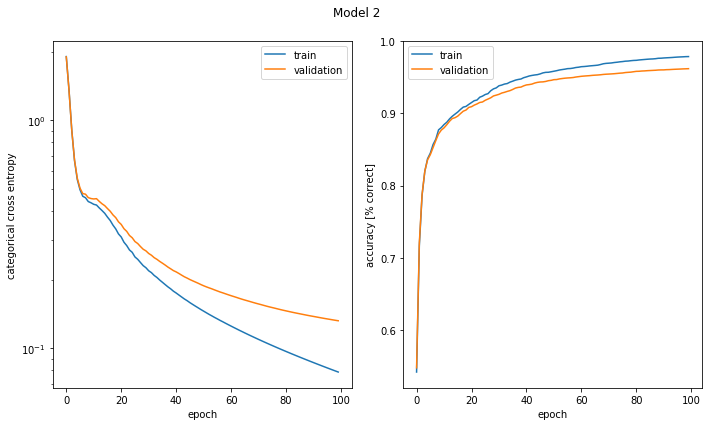

In [25]:
plot_report(train2, title="Model 2")

In [26]:
test2

(tensor(0.9647), 0.11969974637031555, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [27]:
model3, train3 = default_net(train_input, train_target, num_of_hidden_layers=2, loss='ce', num_of_neurons=(784, 500, 200, 10), activation='relu', lr=0.1, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test3 = model3.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
Added Module Name: 5_Dropout 
Added Module Name: 6_Linear 
Added Module Name: 7_Softmax 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 2.191976308822632
key: train_acc -- value: 0.23056666553020477
key: val_loss -- value: 2.1914803981781006
key: val_acc -- value: 0.23706667125225067


  1%|▊                                                                                 | 1/100 [00:02<04:18,  2.61s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 2.002570390701294
key: train_acc -- value: 0.5841666460037231
key: val_loss -- value: 2.001519203186035
key: val_acc -- value: 0.5816666483879089


  2%|█▋                                                                                | 2/100 [00:05<04:27,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.7538825273513794
key: train_acc -- value: 0.6735000014305115
key: val_loss -- value: 1.751596212387085
key: val_acc -- value: 0.6684333086013794


  3%|██▍                                                                               | 3/100 [00:08<04:26,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.429075837135315
key: train_acc -- value: 0.7142333388328552
key: val_loss -- value: 1.4247496128082275
key: val_acc -- value: 0.7123666405677795


  4%|███▎                                                                              | 4/100 [00:11<04:25,  2.76s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.0845941305160522
key: train_acc -- value: 0.7405999898910522
key: val_loss -- value: 1.0787999629974365
key: val_acc -- value: 0.7416666746139526


  5%|████                                                                              | 5/100 [00:13<04:22,  2.77s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.8004594445228577
key: train_acc -- value: 0.7956666946411133
key: val_loss -- value: 0.7973894476890564
key: val_acc -- value: 0.793833315372467


  6%|████▉                                                                             | 6/100 [00:16<04:19,  2.76s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6628000736236572
key: train_acc -- value: 0.8052999973297119
key: val_loss -- value: 0.6668705344200134
key: val_acc -- value: 0.8032333254814148


  7%|█████▋                                                                            | 7/100 [00:19<04:14,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6349551677703857
key: train_acc -- value: 0.7857000231742859
key: val_loss -- value: 0.6355723738670349
key: val_acc -- value: 0.7878000140190125


  8%|██████▌                                                                           | 8/100 [00:22<04:14,  2.76s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.7002052664756775
key: train_acc -- value: 0.7590000033378601
key: val_loss -- value: 0.7203881144523621
key: val_acc -- value: 0.7518333196640015


  9%|███████▍                                                                          | 9/100 [00:24<04:10,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.7197661399841309
key: train_acc -- value: 0.6852333545684814
key: val_loss -- value: 1.692611575126648
key: val_acc -- value: 0.6898999810218811


 10%|████████                                                                         | 10/100 [00:27<04:07,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 2.4452383518218994
key: train_acc -- value: 0.6153333187103271
key: val_loss -- value: 2.446154832839966
key: val_acc -- value: 0.6198999881744385


 11%|████████▉                                                                        | 11/100 [00:30<04:02,  2.73s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 3.44488525390625
key: train_acc -- value: 0.540233314037323
key: val_loss -- value: 3.5622363090515137
key: val_acc -- value: 0.5313000082969666


 12%|█████████▋                                                                       | 12/100 [00:32<03:59,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.5987296104431152
key: train_acc -- value: 0.6129000186920166
key: val_loss -- value: 1.6010736227035522
key: val_acc -- value: 0.6107666492462158


 13%|██████████▌                                                                      | 13/100 [00:35<03:56,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.8749889731407166
key: train_acc -- value: 0.7185333371162415
key: val_loss -- value: 0.8679150938987732
key: val_acc -- value: 0.7201333045959473


 14%|███████████▎                                                                     | 14/100 [00:38<03:54,  2.72s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.0080420970916748
key: train_acc -- value: 0.666866660118103
key: val_loss -- value: 0.9983032941818237
key: val_acc -- value: 0.6777333617210388


 15%|████████████▏                                                                    | 15/100 [00:41<03:52,  2.74s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.0701385736465454
key: train_acc -- value: 0.7014999985694885
key: val_loss -- value: 1.0601285696029663
key: val_acc -- value: 0.708133339881897


 16%|████████████▉                                                                    | 16/100 [00:43<03:50,  2.75s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 1.0394046306610107
key: train_acc -- value: 0.7194666862487793
key: val_loss -- value: 1.030280590057373
key: val_acc -- value: 0.7201333045959473


 17%|█████████████▊                                                                   | 17/100 [00:46<03:48,  2.76s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.887733519077301
key: train_acc -- value: 0.7381666898727417
key: val_loss -- value: 0.880277156829834
key: val_acc -- value: 0.7414000034332275


 18%|██████████████▌                                                                  | 18/100 [00:49<03:46,  2.77s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.6686984896659851
key: train_acc -- value: 0.7875333428382874
key: val_loss -- value: 0.6634787321090698
key: val_acc -- value: 0.7893333435058594


 19%|███████████████▍                                                                 | 19/100 [00:52<03:44,  2.77s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.5258345007896423
key: train_acc -- value: 0.8248000144958496
key: val_loss -- value: 0.5226687788963318
key: val_acc -- value: 0.8275333046913147


 20%|████████████████▏                                                                | 20/100 [00:55<03:42,  2.78s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4750177264213562
key: train_acc -- value: 0.8537333607673645
key: val_loss -- value: 0.4786387085914612
key: val_acc -- value: 0.852566659450531


 21%|█████████████████                                                                | 21/100 [00:58<03:40,  2.79s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4740752875804901
key: train_acc -- value: 0.8581666946411133
key: val_loss -- value: 0.4853855073451996
key: val_acc -- value: 0.8543333411216736


 22%|█████████████████▊                                                               | 22/100 [01:01<03:37,  2.79s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4911351501941681
key: train_acc -- value: 0.8544666767120361
key: val_loss -- value: 0.5045470595359802
key: val_acc -- value: 0.8491666913032532


 23%|██████████████████▋                                                              | 23/100 [01:04<03:35,  2.79s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.43129590153694153
key: train_acc -- value: 0.8784000277519226
key: val_loss -- value: 0.43892380595207214
key: val_acc -- value: 0.8742666840553284


 24%|███████████████████▍                                                             | 24/100 [01:07<03:32,  2.80s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4110245406627655
key: train_acc -- value: 0.8892333507537842
key: val_loss -- value: 0.41305458545684814
key: val_acc -- value: 0.887066662311554


 25%|████████████████████▎                                                            | 25/100 [01:09<03:29,  2.80s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.423337459564209
key: train_acc -- value: 0.8879666924476624
key: val_loss -- value: 0.4241812825202942
key: val_acc -- value: 0.8861333131790161


 26%|█████████████████████                                                            | 26/100 [01:13<03:28,  2.81s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.4130024313926697
key: train_acc -- value: 0.8932333588600159
key: val_loss -- value: 0.4167814552783966
key: val_acc -- value: 0.8909333348274231


 27%|█████████████████████▊                                                           | 27/100 [01:16<03:26,  2.83s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.38364478945732117
key: train_acc -- value: 0.8984666466712952
key: val_loss -- value: 0.3906434178352356
key: val_acc -- value: 0.8964999914169312


 28%|██████████████████████▋                                                          | 28/100 [01:19<03:24,  2.84s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3585220277309418
key: train_acc -- value: 0.9028666615486145
key: val_loss -- value: 0.36830905079841614
key: val_acc -- value: 0.8995000123977661


 29%|███████████████████████▍                                                         | 29/100 [01:22<03:21,  2.84s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3405168056488037
key: train_acc -- value: 0.9057999849319458
key: val_loss -- value: 0.35194137692451477
key: val_acc -- value: 0.9031333327293396


 30%|████████████████████████▎                                                        | 30/100 [01:25<03:18,  2.84s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3273804485797882
key: train_acc -- value: 0.9068999886512756
key: val_loss -- value: 0.33755674958229065
key: val_acc -- value: 0.9045000076293945


 31%|█████████████████████████                                                        | 31/100 [01:28<03:16,  2.85s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.3072693645954132
key: train_acc -- value: 0.9120000004768372
key: val_loss -- value: 0.31500443816185
key: val_acc -- value: 0.9093000292778015


 32%|█████████████████████████▉                                                       | 32/100 [01:31<03:14,  2.86s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2862773537635803
key: train_acc -- value: 0.9186333417892456
key: val_loss -- value: 0.29231515526771545
key: val_acc -- value: 0.9160666465759277


 33%|██████████████████████████▋                                                      | 33/100 [01:34<03:12,  2.87s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2769148051738739
key: train_acc -- value: 0.9202333092689514
key: val_loss -- value: 0.28236278891563416
key: val_acc -- value: 0.919700026512146


 34%|███████████████████████████▌                                                     | 34/100 [01:38<03:10,  2.88s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2691294848918915
key: train_acc -- value: 0.9223333597183228
key: val_loss -- value: 0.27499035000801086
key: val_acc -- value: 0.9212333559989929


 35%|████████████████████████████▎                                                    | 35/100 [01:41<03:07,  2.89s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2576848566532135
key: train_acc -- value: 0.925000011920929
key: val_loss -- value: 0.26471665501594543
key: val_acc -- value: 0.9236999750137329


 36%|█████████████████████████████▏                                                   | 36/100 [01:44<03:05,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24784836173057556
key: train_acc -- value: 0.9276000261306763
key: val_loss -- value: 0.2563169300556183
key: val_acc -- value: 0.9257000088691711


 37%|█████████████████████████████▉                                                   | 37/100 [01:47<03:02,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.24046708643436432
key: train_acc -- value: 0.9299666881561279
key: val_loss -- value: 0.2500150799751282
key: val_acc -- value: 0.926800012588501


 38%|██████████████████████████████▊                                                  | 38/100 [01:50<02:59,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.2332942634820938
key: train_acc -- value: 0.932533323764801
key: val_loss -- value: 0.24373789131641388
key: val_acc -- value: 0.9278666377067566


 39%|███████████████████████████████▌                                                 | 39/100 [01:53<02:57,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.22645938396453857
key: train_acc -- value: 0.9321666955947876
key: val_loss -- value: 0.2378651201725006
key: val_acc -- value: 0.9298666715621948


 40%|████████████████████████████████▍                                                | 40/100 [01:56<02:54,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.21840481460094452
key: train_acc -- value: 0.9347333312034607
key: val_loss -- value: 0.2305920571088791
key: val_acc -- value: 0.9316999912261963


 41%|█████████████████████████████████▏                                               | 41/100 [01:59<02:51,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.20801962912082672
key: train_acc -- value: 0.9377999901771545
key: val_loss -- value: 0.22068382799625397
key: val_acc -- value: 0.9352666735649109


 42%|██████████████████████████████████                                               | 42/100 [02:01<02:48,  2.90s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.19914662837982178
key: train_acc -- value: 0.9401999711990356
key: val_loss -- value: 0.21227724850177765
key: val_acc -- value: 0.9373999834060669


 43%|██████████████████████████████████▊                                              | 43/100 [02:05<02:45,  2.91s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1938616931438446
key: train_acc -- value: 0.941433310508728
key: val_loss -- value: 0.2075691670179367
key: val_acc -- value: 0.9382666945457458


 44%|███████████████████████████████████▋                                             | 44/100 [02:08<02:43,  2.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.18964146077632904
key: train_acc -- value: 0.9429000020027161
key: val_loss -- value: 0.20412001013755798
key: val_acc -- value: 0.9380333423614502


 45%|████████████████████████████████████▍                                            | 45/100 [02:11<02:40,  2.92s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1842353343963623
key: train_acc -- value: 0.944266676902771
key: val_loss -- value: 0.19958236813545227
key: val_acc -- value: 0.9393666386604309


 46%|█████████████████████████████████████▎                                           | 46/100 [02:14<02:38,  2.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1784137338399887
key: train_acc -- value: 0.9459666609764099
key: val_loss -- value: 0.19469110667705536
key: val_acc -- value: 0.9408666491508484


 47%|██████████████████████████████████████                                           | 47/100 [02:17<02:35,  2.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.17363426089286804
key: train_acc -- value: 0.9470666646957397
key: val_loss -- value: 0.19096800684928894
key: val_acc -- value: 0.9424999952316284


 48%|██████████████████████████████████████▉                                          | 48/100 [02:20<02:32,  2.93s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16981863975524902
key: train_acc -- value: 0.9484999775886536
key: val_loss -- value: 0.18826916813850403
key: val_acc -- value: 0.9438333511352539


 49%|███████████████████████████████████████▋                                         | 49/100 [02:23<02:29,  2.94s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16613338887691498
key: train_acc -- value: 0.9496999979019165
key: val_loss -- value: 0.1855495125055313
key: val_acc -- value: 0.9448999762535095


 50%|████████████████████████████████████████▌                                        | 50/100 [02:27<02:27,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.16221638023853302
key: train_acc -- value: 0.9506666660308838
key: val_loss -- value: 0.18243712186813354
key: val_acc -- value: 0.9456666707992554


 51%|█████████████████████████████████████████▎                                       | 51/100 [02:30<02:24,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1583118438720703
key: train_acc -- value: 0.9514333605766296
key: val_loss -- value: 0.1792066991329193
key: val_acc -- value: 0.945900022983551


 52%|██████████████████████████████████████████                                       | 52/100 [02:33<02:21,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.15455056726932526
key: train_acc -- value: 0.9526333212852478
key: val_loss -- value: 0.17603132128715515
key: val_acc -- value: 0.9463666677474976


 53%|██████████████████████████████████████████▉                                      | 53/100 [02:36<02:18,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1508311778306961
key: train_acc -- value: 0.9538999795913696
key: val_loss -- value: 0.17285534739494324
key: val_acc -- value: 0.9471666812896729


 54%|███████████████████████████████████████████▋                                     | 54/100 [02:39<02:15,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1472247987985611
key: train_acc -- value: 0.9545000195503235
key: val_loss -- value: 0.16977840662002563
key: val_acc -- value: 0.9482666850090027


 55%|████████████████████████████████████████████▌                                    | 55/100 [02:42<02:12,  2.95s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14384086430072784
key: train_acc -- value: 0.9559666514396667
key: val_loss -- value: 0.16690658032894135
key: val_acc -- value: 0.949733316898346


 56%|█████████████████████████████████████████████▎                                   | 56/100 [02:45<02:10,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.14060078561306
key: train_acc -- value: 0.9571666717529297
key: val_loss -- value: 0.1641610711812973
key: val_acc -- value: 0.9502333402633667


 57%|██████████████████████████████████████████████▏                                  | 57/100 [02:48<02:07,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13738909363746643
key: train_acc -- value: 0.958133339881897
key: val_loss -- value: 0.16148017346858978
key: val_acc -- value: 0.9512666463851929


 58%|██████████████████████████████████████████████▉                                  | 58/100 [02:51<02:04,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13431161642074585
key: train_acc -- value: 0.958899974822998
key: val_loss -- value: 0.1590488702058792
key: val_acc -- value: 0.9521999955177307


 59%|███████████████████████████████████████████████▊                                 | 59/100 [02:54<02:01,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.13153710961341858
key: train_acc -- value: 0.9596666693687439
key: val_loss -- value: 0.15707126259803772
key: val_acc -- value: 0.95333331823349


 60%|████████████████████████████████████████████████▌                                | 60/100 [02:57<01:58,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12905915081501007
key: train_acc -- value: 0.9606333374977112
key: val_loss -- value: 0.1554846465587616
key: val_acc -- value: 0.9539999961853027


 61%|█████████████████████████████████████████████████▍                               | 61/100 [03:00<01:55,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1266356110572815
key: train_acc -- value: 0.9614999890327454
key: val_loss -- value: 0.15393298864364624
key: val_acc -- value: 0.954633355140686


 62%|██████████████████████████████████████████████████▏                              | 62/100 [03:03<01:52,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12407984584569931
key: train_acc -- value: 0.9627333283424377
key: val_loss -- value: 0.15215392410755157
key: val_acc -- value: 0.9549999833106995


 63%|███████████████████████████████████████████████████                              | 63/100 [03:06<01:49,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.12152009457349777
key: train_acc -- value: 0.9637666940689087
key: val_loss -- value: 0.15021498501300812
key: val_acc -- value: 0.9548666477203369


 64%|███████████████████████████████████████████████████▊                             | 64/100 [03:09<01:46,  2.96s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11922194063663483
key: train_acc -- value: 0.9643333554267883
key: val_loss -- value: 0.14835892617702484
key: val_acc -- value: 0.9551666378974915


 65%|████████████████████████████████████████████████████▋                            | 65/100 [03:12<01:43,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11717982590198517
key: train_acc -- value: 0.9652666449546814
key: val_loss -- value: 0.14665590226650238
key: val_acc -- value: 0.9556999802589417


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [03:16<01:41,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1151687428355217
key: train_acc -- value: 0.9657999873161316
key: val_loss -- value: 0.14497143030166626
key: val_acc -- value: 0.95660001039505


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [03:19<01:38,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11305070668458939
key: train_acc -- value: 0.9664999842643738
key: val_loss -- value: 0.14325790107250214
key: val_acc -- value: 0.9570666551589966


 68%|███████████████████████████████████████████████████████                          | 68/100 [03:22<01:35,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.11089538782835007
key: train_acc -- value: 0.966866672039032
key: val_loss -- value: 0.141618549823761
key: val_acc -- value: 0.9573000073432922


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [03:24<01:32,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1088213101029396
key: train_acc -- value: 0.9674999713897705
key: val_loss -- value: 0.14016206562519073
key: val_acc -- value: 0.9578999876976013


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [03:28<01:29,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10689016431570053
key: train_acc -- value: 0.9680666923522949
key: val_loss -- value: 0.13889676332473755
key: val_acc -- value: 0.9582333564758301


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [03:31<01:26,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10509001463651657
key: train_acc -- value: 0.9686333537101746
key: val_loss -- value: 0.13775469362735748
key: val_acc -- value: 0.958899974822998


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:34<01:23,  2.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.10334819555282593
key: train_acc -- value: 0.9694333076477051
key: val_loss -- value: 0.1366095393896103
key: val_acc -- value: 0.9591666460037231


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [03:37<01:20,  2.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.1015777438879013
key: train_acc -- value: 0.9702000021934509
key: val_loss -- value: 0.13536502420902252
key: val_acc -- value: 0.9596666693687439


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [03:40<01:17,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09977462887763977
key: train_acc -- value: 0.9707333445549011
key: val_loss -- value: 0.13404203951358795
key: val_acc -- value: 0.9602000117301941


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [03:42<01:14,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09803495556116104
key: train_acc -- value: 0.9711666703224182
key: val_loss -- value: 0.13278193771839142
key: val_acc -- value: 0.960433304309845


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [03:45<01:11,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09641240537166595
key: train_acc -- value: 0.9715666770935059
key: val_loss -- value: 0.1316731572151184
key: val_acc -- value: 0.9605666399002075


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [03:48<01:08,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09486947953701019
key: train_acc -- value: 0.9718999862670898
key: val_loss -- value: 0.130692258477211
key: val_acc -- value: 0.9609666466712952


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [03:51<01:05,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09334252029657364
key: train_acc -- value: 0.9722999930381775
key: val_loss -- value: 0.12977486848831177
key: val_acc -- value: 0.9611999988555908


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [03:54<01:02,  2.97s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09182984381914139
key: train_acc -- value: 0.9726999998092651
key: val_loss -- value: 0.12889420986175537
key: val_acc -- value: 0.961566686630249


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [03:58<00:59,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.09035272896289825
key: train_acc -- value: 0.9729666709899902
key: val_loss -- value: 0.1280333399772644
key: val_acc -- value: 0.9618333578109741


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [04:01<00:56,  2.98s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08890827745199203
key: train_acc -- value: 0.9736666679382324
key: val_loss -- value: 0.1271553635597229
key: val_acc -- value: 0.9618333578109741


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [04:04<00:53,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08748813718557358
key: train_acc -- value: 0.9738333225250244
key: val_loss -- value: 0.126234769821167
key: val_acc -- value: 0.9620333313941956


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [04:08<00:50,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08610504865646362
key: train_acc -- value: 0.9743666648864746
key: val_loss -- value: 0.12528935074806213
key: val_acc -- value: 0.9624666571617126


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [04:11<00:47,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08476532250642776
key: train_acc -- value: 0.9747999906539917
key: val_loss -- value: 0.12436086684465408
key: val_acc -- value: 0.9626333117485046


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [04:14<00:44,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08346070349216461
key: train_acc -- value: 0.9753000140190125
key: val_loss -- value: 0.12346680462360382
key: val_acc -- value: 0.9628333449363708


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [04:17<00:41,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08216916024684906
key: train_acc -- value: 0.9756333231925964
key: val_loss -- value: 0.12261812388896942
key: val_acc -- value: 0.9630333185195923


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [04:20<00:38,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.08088936656713486
key: train_acc -- value: 0.9761999845504761
key: val_loss -- value: 0.1218193769454956
key: val_acc -- value: 0.9631999731063843


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [04:23<00:35,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07963878661394119
key: train_acc -- value: 0.9764999747276306
key: val_loss -- value: 0.12108266353607178
key: val_acc -- value: 0.9634333252906799


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [04:26<00:32,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07843419909477234
key: train_acc -- value: 0.9769333600997925
key: val_loss -- value: 0.12039802223443985
key: val_acc -- value: 0.9634000062942505


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [04:29<00:29,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07726279646158218
key: train_acc -- value: 0.9775000214576721
key: val_loss -- value: 0.11973101645708084
key: val_acc -- value: 0.963699996471405


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [04:32<00:26,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07610482722520828
key: train_acc -- value: 0.9780666828155518
key: val_loss -- value: 0.11904781311750412
key: val_acc -- value: 0.963866651058197


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [04:35<00:23,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07495755702257156
key: train_acc -- value: 0.9783999919891357
key: val_loss -- value: 0.11834616959095001
key: val_acc -- value: 0.9642000198364258


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [04:38<00:20,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07383473217487335
key: train_acc -- value: 0.9786333441734314
key: val_loss -- value: 0.11764972656965256
key: val_acc -- value: 0.9643999934196472


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [04:41<00:17,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07274169474840164
key: train_acc -- value: 0.9789999723434448
key: val_loss -- value: 0.11698103696107864
key: val_acc -- value: 0.9646000266075134


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [04:44<00:14,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07167142629623413
key: train_acc -- value: 0.9794333577156067
key: val_loss -- value: 0.11633904278278351
key: val_acc -- value: 0.9646666646003723


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [04:47<00:11,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.07061757147312164
key: train_acc -- value: 0.9799666404724121
key: val_loss -- value: 0.11571884900331497
key: val_acc -- value: 0.964900016784668


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [04:50<00:08,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.06957942247390747
key: train_acc -- value: 0.9803000092506409
key: val_loss -- value: 0.11511611193418503
key: val_acc -- value: 0.9651333093643188


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [04:53<00:05,  2.99s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.06855817884206772
key: train_acc -- value: 0.980566680431366
key: val_loss -- value: 0.11452294886112213
key: val_acc -- value: 0.9653666615486145


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [04:56<00:02,  3.00s/it]

row_sum: (30000,) -- row_sum_sum: 30000
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
torch.Size([30000, 10])  --  torch.Size([30000, 10])
key: train_loss -- value: 0.06755488365888596
key: train_acc -- value: 0.9809333086013794
key: val_loss -- value: 0.11393298208713531
key: val_acc -- value: 0.9653666615486145


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:59<00:00,  3.00s/it]


torch.Size([10000, 10])  --  torch.Size([10000, 10])


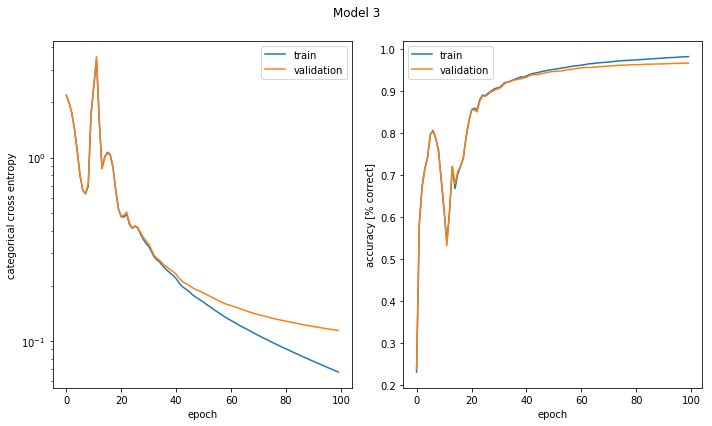

In [28]:
plot_report(train3, title="Model 3")

In [29]:
test3

(tensor(0.9657), 0.10974247753620148, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [42]:
model4, train4 = default_net(train_input, train_target_mse, num_of_hidden_layers=1, loss='mse', num_of_neurons=(784, 200, 10), activation='tanh', lr=0.01, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=300, val_split=0.5, verbose=0)
test4 = model4.evaluate(test_input, test_target_mse, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_Tanh 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_Tanh 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

key: train_loss -- value: 3.5560340881347656
key: train_acc -- value: 0.24369999766349792
key: val_loss -- value: 3.558211088180542
key: val_acc -- value: 0.24213333427906036


  0%|▎                                                                                 | 1/300 [00:00<03:34,  1.39it/s]

key: train_loss -- value: 3.5564746856689453
key: train_acc -- value: 0.3479333221912384
key: val_loss -- value: 3.5567469596862793
key: val_acc -- value: 0.3462333381175995


  1%|▌                                                                                 | 2/300 [00:01<03:45,  1.32it/s]

key: train_loss -- value: 3.5768611431121826
key: train_acc -- value: 0.3591333329677582
key: val_loss -- value: 3.5755374431610107
key: val_acc -- value: 0.3577333390712738


  1%|▊                                                                                 | 3/300 [00:02<03:45,  1.32it/s]

key: train_loss -- value: 3.4359633922576904
key: train_acc -- value: 0.3269333243370056
key: val_loss -- value: 3.4321141242980957
key: val_acc -- value: 0.3267666697502136


  1%|█                                                                                 | 4/300 [00:03<03:44,  1.32it/s]

key: train_loss -- value: 3.2147703170776367
key: train_acc -- value: 0.30006667971611023
key: val_loss -- value: 3.207245349884033
key: val_acc -- value: 0.3012666702270508


  2%|█▎                                                                                | 5/300 [00:03<03:46,  1.30it/s]

key: train_loss -- value: 3.208407402038574
key: train_acc -- value: 0.30406665802001953
key: val_loss -- value: 3.203169107437134
key: val_acc -- value: 0.30426666140556335


  2%|█▋                                                                                | 6/300 [00:04<03:47,  1.29it/s]

key: train_loss -- value: 3.205066442489624
key: train_acc -- value: 0.33843332529067993
key: val_loss -- value: 3.206260919570923
key: val_acc -- value: 0.3359333276748657


  2%|█▉                                                                                | 7/300 [00:05<03:51,  1.27it/s]

key: train_loss -- value: 2.983855962753296
key: train_acc -- value: 0.3827666640281677
key: val_loss -- value: 2.9859397411346436
key: val_acc -- value: 0.37903332710266113


  3%|██▏                                                                               | 8/300 [00:06<03:52,  1.26it/s]

key: train_loss -- value: 2.948960304260254
key: train_acc -- value: 0.3851333260536194
key: val_loss -- value: 2.949320077896118
key: val_acc -- value: 0.38413333892822266


  3%|██▍                                                                               | 9/300 [00:07<03:51,  1.26it/s]

key: train_loss -- value: 2.8696863651275635
key: train_acc -- value: 0.42926666140556335
key: val_loss -- value: 2.8715648651123047
key: val_acc -- value: 0.428933322429657


  3%|██▋                                                                              | 10/300 [00:08<03:52,  1.25it/s]

key: train_loss -- value: 2.7827701568603516
key: train_acc -- value: 0.44103333353996277
key: val_loss -- value: 2.791186809539795
key: val_acc -- value: 0.43619999289512634


  4%|██▉                                                                              | 11/300 [00:08<03:51,  1.25it/s]

key: train_loss -- value: 2.7925782203674316
key: train_acc -- value: 0.4321666657924652
key: val_loss -- value: 2.8053128719329834
key: val_acc -- value: 0.4290333390235901


  4%|███▏                                                                             | 12/300 [00:09<03:50,  1.25it/s]

key: train_loss -- value: 2.731809139251709
key: train_acc -- value: 0.45073333382606506
key: val_loss -- value: 2.7465686798095703
key: val_acc -- value: 0.4463333189487457


  4%|███▌                                                                             | 13/300 [00:10<03:50,  1.25it/s]

key: train_loss -- value: 2.6486265659332275
key: train_acc -- value: 0.4653666615486145
key: val_loss -- value: 2.664445161819458
key: val_acc -- value: 0.460099995136261


  5%|███▊                                                                             | 14/300 [00:11<03:52,  1.23it/s]

key: train_loss -- value: 2.54643177986145
key: train_acc -- value: 0.487199991941452
key: val_loss -- value: 2.5599093437194824
key: val_acc -- value: 0.48010000586509705


  5%|████                                                                             | 15/300 [00:12<03:50,  1.24it/s]

key: train_loss -- value: 2.483760118484497
key: train_acc -- value: 0.5022666454315186
key: val_loss -- value: 2.493957042694092
key: val_acc -- value: 0.4987333416938782


  5%|████▎                                                                            | 16/300 [00:12<03:49,  1.24it/s]

key: train_loss -- value: 2.388981819152832
key: train_acc -- value: 0.5183333158493042
key: val_loss -- value: 2.3978214263916016
key: val_acc -- value: 0.5163333415985107


  6%|████▌                                                                            | 17/300 [00:13<03:48,  1.24it/s]

key: train_loss -- value: 2.2481119632720947
key: train_acc -- value: 0.548966646194458
key: val_loss -- value: 2.258629083633423
key: val_acc -- value: 0.5440666675567627


  6%|████▊                                                                            | 18/300 [00:14<03:47,  1.24it/s]

key: train_loss -- value: 2.1621434688568115
key: train_acc -- value: 0.5863333344459534
key: val_loss -- value: 2.1775054931640625
key: val_acc -- value: 0.57833331823349


  6%|█████▏                                                                           | 19/300 [00:15<03:46,  1.24it/s]

key: train_loss -- value: 2.231940269470215
key: train_acc -- value: 0.5898333191871643
key: val_loss -- value: 2.252108573913574
key: val_acc -- value: 0.5831999778747559


  7%|█████▍                                                                           | 20/300 [00:16<03:45,  1.24it/s]

key: train_loss -- value: 2.1848766803741455
key: train_acc -- value: 0.6043000221252441
key: val_loss -- value: 2.206207275390625
key: val_acc -- value: 0.597266674041748


  7%|█████▋                                                                           | 21/300 [00:16<03:44,  1.24it/s]

key: train_loss -- value: 1.9785369634628296
key: train_acc -- value: 0.642133355140686
key: val_loss -- value: 1.9951484203338623
key: val_acc -- value: 0.6359000205993652


  7%|█████▉                                                                           | 22/300 [00:17<03:43,  1.24it/s]

key: train_loss -- value: 1.8820489645004272
key: train_acc -- value: 0.6620333194732666
key: val_loss -- value: 1.8893712759017944
key: val_acc -- value: 0.6589666604995728


  8%|██████▏                                                                          | 23/300 [00:18<03:43,  1.24it/s]

key: train_loss -- value: 1.9333829879760742
key: train_acc -- value: 0.6568999886512756
key: val_loss -- value: 1.934178352355957
key: val_acc -- value: 0.6553666591644287


  8%|██████▍                                                                          | 24/300 [00:19<03:42,  1.24it/s]

key: train_loss -- value: 1.884544849395752
key: train_acc -- value: 0.6668000221252441
key: val_loss -- value: 1.885658860206604
key: val_acc -- value: 0.664733350276947


  8%|██████▊                                                                          | 25/300 [00:20<03:41,  1.24it/s]

key: train_loss -- value: 1.8117021322250366
key: train_acc -- value: 0.6797333359718323
key: val_loss -- value: 1.8166232109069824
key: val_acc -- value: 0.6786666512489319


  9%|███████                                                                          | 26/300 [00:21<03:41,  1.23it/s]

key: train_loss -- value: 1.7892563343048096
key: train_acc -- value: 0.6815999746322632
key: val_loss -- value: 1.7973042726516724
key: val_acc -- value: 0.6816999912261963


  9%|███████▎                                                                         | 27/300 [00:21<03:41,  1.23it/s]

key: train_loss -- value: 1.7399052381515503
key: train_acc -- value: 0.6872000098228455
key: val_loss -- value: 1.7482367753982544
key: val_acc -- value: 0.6854666471481323


  9%|███████▌                                                                         | 28/300 [00:22<03:41,  1.23it/s]

key: train_loss -- value: 1.6647206544876099
key: train_acc -- value: 0.6938333511352539
key: val_loss -- value: 1.6713453531265259
key: val_acc -- value: 0.6924999952316284


 10%|███████▊                                                                         | 29/300 [00:23<03:40,  1.23it/s]

key: train_loss -- value: 1.634666919708252
key: train_acc -- value: 0.6948666572570801
key: val_loss -- value: 1.6402896642684937
key: val_acc -- value: 0.6933666467666626


 10%|████████                                                                         | 30/300 [00:24<03:40,  1.23it/s]

key: train_loss -- value: 1.635332465171814
key: train_acc -- value: 0.694266676902771
key: val_loss -- value: 1.6413829326629639
key: val_acc -- value: 0.6936333179473877


 10%|████████▎                                                                        | 31/300 [00:25<03:40,  1.22it/s]

key: train_loss -- value: 1.6080715656280518
key: train_acc -- value: 0.6966666579246521
key: val_loss -- value: 1.6158021688461304
key: val_acc -- value: 0.6966000199317932


 11%|████████▋                                                                        | 32/300 [00:26<03:39,  1.22it/s]

key: train_loss -- value: 1.5816494226455688
key: train_acc -- value: 0.6991666555404663
key: val_loss -- value: 1.5904051065444946
key: val_acc -- value: 0.698033332824707


 11%|████████▉                                                                        | 33/300 [00:27<03:38,  1.22it/s]

key: train_loss -- value: 1.5654375553131104
key: train_acc -- value: 0.7023666501045227
key: val_loss -- value: 1.5738601684570312
key: val_acc -- value: 0.7000333070755005


 11%|█████████▏                                                                       | 34/300 [00:27<03:38,  1.22it/s]

key: train_loss -- value: 1.5459201335906982
key: train_acc -- value: 0.7051666378974915
key: val_loss -- value: 1.5533177852630615
key: val_acc -- value: 0.7035333514213562


 12%|█████████▍                                                                       | 35/300 [00:28<03:37,  1.22it/s]

key: train_loss -- value: 1.5195127725601196
key: train_acc -- value: 0.7086666822433472
key: val_loss -- value: 1.5258482694625854
key: val_acc -- value: 0.7071999907493591


 12%|█████████▋                                                                       | 36/300 [00:29<03:37,  1.22it/s]

key: train_loss -- value: 1.4949986934661865
key: train_acc -- value: 0.7107999920845032
key: val_loss -- value: 1.5005160570144653
key: val_acc -- value: 0.7108666896820068


 12%|█████████▉                                                                       | 37/300 [00:30<03:35,  1.22it/s]

key: train_loss -- value: 1.4804739952087402
key: train_acc -- value: 0.7124333381652832
key: val_loss -- value: 1.485400915145874
key: val_acc -- value: 0.7131999731063843


 13%|██████████▎                                                                      | 38/300 [00:31<03:35,  1.21it/s]

key: train_loss -- value: 1.4744399785995483
key: train_acc -- value: 0.7131666541099548
key: val_loss -- value: 1.4791555404663086
key: val_acc -- value: 0.7142333388328552


 13%|██████████▌                                                                      | 39/300 [00:32<03:35,  1.21it/s]

key: train_loss -- value: 1.4678099155426025
key: train_acc -- value: 0.714033305644989
key: val_loss -- value: 1.4727917909622192
key: val_acc -- value: 0.7149999737739563


 13%|██████████▊                                                                      | 40/300 [00:33<03:34,  1.21it/s]

key: train_loss -- value: 1.4542139768600464
key: train_acc -- value: 0.7162666916847229
key: val_loss -- value: 1.4598026275634766
key: val_acc -- value: 0.7171333432197571


 14%|███████████                                                                      | 41/300 [00:33<03:34,  1.21it/s]

key: train_loss -- value: 1.4375263452529907
key: train_acc -- value: 0.7191333174705505
key: val_loss -- value: 1.4437930583953857
key: val_acc -- value: 0.7186999917030334


 14%|███████████▎                                                                     | 42/300 [00:34<03:33,  1.21it/s]

key: train_loss -- value: 1.4238282442092896
key: train_acc -- value: 0.7213666439056396
key: val_loss -- value: 1.4306976795196533
key: val_acc -- value: 0.7212666869163513


 14%|███████████▌                                                                     | 43/300 [00:35<03:33,  1.21it/s]

key: train_loss -- value: 1.413859486579895
key: train_acc -- value: 0.7229666709899902
key: val_loss -- value: 1.421220302581787
key: val_acc -- value: 0.7219333052635193


 15%|███████████▉                                                                     | 44/300 [00:36<03:32,  1.21it/s]

key: train_loss -- value: 1.405369520187378
key: train_acc -- value: 0.7242666482925415
key: val_loss -- value: 1.4130849838256836
key: val_acc -- value: 0.7230333089828491


 15%|████████████▏                                                                    | 45/300 [00:37<03:31,  1.20it/s]

key: train_loss -- value: 1.3967746496200562
key: train_acc -- value: 0.725433349609375
key: val_loss -- value: 1.4046788215637207
key: val_acc -- value: 0.724133312702179


 15%|████████████▍                                                                    | 46/300 [00:38<03:31,  1.20it/s]

key: train_loss -- value: 1.388095498085022
key: train_acc -- value: 0.7261999845504761
key: val_loss -- value: 1.3960872888565063
key: val_acc -- value: 0.7249000072479248


 16%|████████████▋                                                                    | 47/300 [00:39<03:30,  1.20it/s]

key: train_loss -- value: 1.3800787925720215
key: train_acc -- value: 0.727066695690155
key: val_loss -- value: 1.388128399848938
key: val_acc -- value: 0.7261333465576172


 16%|████████████▉                                                                    | 48/300 [00:40<03:30,  1.20it/s]

key: train_loss -- value: 1.3732364177703857
key: train_acc -- value: 0.7281333208084106
key: val_loss -- value: 1.3814563751220703
key: val_acc -- value: 0.7271999716758728


 16%|█████████████▏                                                                   | 49/300 [00:40<03:29,  1.20it/s]

key: train_loss -- value: 1.3672555685043335
key: train_acc -- value: 0.728866696357727
key: val_loss -- value: 1.3757917881011963
key: val_acc -- value: 0.7279333472251892


 17%|█████████████▌                                                                   | 50/300 [00:41<03:29,  1.20it/s]

key: train_loss -- value: 1.3611116409301758
key: train_acc -- value: 0.7298666834831238
key: val_loss -- value: 1.3700944185256958
key: val_acc -- value: 0.7284333109855652


 17%|█████████████▊                                                                   | 51/300 [00:42<03:28,  1.19it/s]

key: train_loss -- value: 1.354035496711731
key: train_acc -- value: 0.7307666540145874
key: val_loss -- value: 1.3635140657424927
key: val_acc -- value: 0.7289000153541565


 17%|██████████████                                                                   | 52/300 [00:43<03:28,  1.19it/s]

key: train_loss -- value: 1.346394419670105
key: train_acc -- value: 0.7313666939735413
key: val_loss -- value: 1.3563523292541504
key: val_acc -- value: 0.7294333577156067


 18%|██████████████▎                                                                  | 53/300 [00:44<03:27,  1.19it/s]

key: train_loss -- value: 1.3393234014511108
key: train_acc -- value: 0.7321000099182129
key: val_loss -- value: 1.3496930599212646
key: val_acc -- value: 0.7302666902542114


 18%|██████████████▌                                                                  | 54/300 [00:45<03:26,  1.19it/s]

key: train_loss -- value: 1.3334949016571045
key: train_acc -- value: 0.7328333258628845
key: val_loss -- value: 1.3442071676254272
key: val_acc -- value: 0.7307999730110168


 18%|██████████████▊                                                                  | 55/300 [00:46<03:26,  1.19it/s]

key: train_loss -- value: 1.3287005424499512
key: train_acc -- value: 0.7336666584014893
key: val_loss -- value: 1.3396825790405273
key: val_acc -- value: 0.7317666411399841


 19%|███████████████                                                                  | 56/300 [00:47<03:25,  1.19it/s]

key: train_loss -- value: 1.3242738246917725
key: train_acc -- value: 0.7343000173568726
key: val_loss -- value: 1.3355048894882202
key: val_acc -- value: 0.7329000234603882


 19%|███████████████▍                                                                 | 57/300 [00:47<03:24,  1.19it/s]

key: train_loss -- value: 1.3197369575500488
key: train_acc -- value: 0.7352666854858398
key: val_loss -- value: 1.3312547206878662
key: val_acc -- value: 0.7336666584014893


 19%|███████████████▋                                                                 | 58/300 [00:48<03:23,  1.19it/s]

key: train_loss -- value: 1.314995288848877
key: train_acc -- value: 0.7358666658401489
key: val_loss -- value: 1.3268786668777466
key: val_acc -- value: 0.7341333627700806


 20%|███████████████▉                                                                 | 59/300 [00:49<03:22,  1.19it/s]

key: train_loss -- value: 1.3101831674575806
key: train_acc -- value: 0.736466646194458
key: val_loss -- value: 1.3225003480911255
key: val_acc -- value: 0.7347666621208191


 20%|████████████████▏                                                                | 60/300 [00:50<03:21,  1.19it/s]

key: train_loss -- value: 1.305402398109436
key: train_acc -- value: 0.7369333505630493
key: val_loss -- value: 1.3182320594787598
key: val_acc -- value: 0.7353000044822693


 20%|████████████████▍                                                                | 61/300 [00:51<03:21,  1.19it/s]

key: train_loss -- value: 1.3008166551589966
key: train_acc -- value: 0.7379000186920166
key: val_loss -- value: 1.3141765594482422
key: val_acc -- value: 0.7361000180244446


 21%|████████████████▋                                                                | 62/300 [00:52<03:20,  1.19it/s]

key: train_loss -- value: 1.2965677976608276
key: train_acc -- value: 0.7383000254631042
key: val_loss -- value: 1.310457706451416
key: val_acc -- value: 0.736466646194458


 21%|█████████████████                                                                | 63/300 [00:53<03:19,  1.19it/s]

key: train_loss -- value: 1.292668104171753
key: train_acc -- value: 0.7386000156402588
key: val_loss -- value: 1.3070635795593262
key: val_acc -- value: 0.7368666529655457


 21%|█████████████████▎                                                               | 64/300 [00:54<03:19,  1.18it/s]

key: train_loss -- value: 1.2890182733535767
key: train_acc -- value: 0.7394000291824341
key: val_loss -- value: 1.3038498163223267
key: val_acc -- value: 0.7371333241462708


 22%|█████████████████▌                                                               | 65/300 [00:54<03:18,  1.18it/s]

key: train_loss -- value: 1.2854708433151245
key: train_acc -- value: 0.7398666739463806
key: val_loss -- value: 1.300683856010437
key: val_acc -- value: 0.737333357334137


 22%|█████████████████▊                                                               | 66/300 [00:55<03:17,  1.18it/s]

key: train_loss -- value: 1.2819310426712036
key: train_acc -- value: 0.7400333285331726
key: val_loss -- value: 1.297481894493103
key: val_acc -- value: 0.737766683101654


 22%|██████████████████                                                               | 67/300 [00:56<03:16,  1.18it/s]

key: train_loss -- value: 1.278462290763855
key: train_acc -- value: 0.7404333353042603
key: val_loss -- value: 1.2943216562271118
key: val_acc -- value: 0.7380333542823792


 23%|██████████████████▎                                                              | 68/300 [00:57<03:16,  1.18it/s]

key: train_loss -- value: 1.2751258611679077
key: train_acc -- value: 0.7407333254814148
key: val_loss -- value: 1.2912743091583252
key: val_acc -- value: 0.7383000254631042


 23%|██████████████████▋                                                              | 69/300 [00:58<03:15,  1.18it/s]

key: train_loss -- value: 1.2719157934188843
key: train_acc -- value: 0.7413666844367981
key: val_loss -- value: 1.2883381843566895
key: val_acc -- value: 0.7388666868209839


 23%|██████████████████▉                                                              | 70/300 [00:59<03:15,  1.18it/s]

key: train_loss -- value: 1.2687523365020752
key: train_acc -- value: 0.7416666746139526
key: val_loss -- value: 1.285441517829895
key: val_acc -- value: 0.739466667175293


 24%|███████████████████▏                                                             | 71/300 [01:00<03:14,  1.18it/s]

key: train_loss -- value: 1.265571117401123
key: train_acc -- value: 0.7425000071525574
key: val_loss -- value: 1.2825210094451904
key: val_acc -- value: 0.7399666905403137


 24%|███████████████████▍                                                             | 72/300 [01:01<03:14,  1.17it/s]

key: train_loss -- value: 1.2624146938323975
key: train_acc -- value: 0.7426999807357788
key: val_loss -- value: 1.2796069383621216
key: val_acc -- value: 0.7406666874885559


 24%|███████████████████▋                                                             | 73/300 [01:02<03:13,  1.17it/s]

key: train_loss -- value: 1.2593421936035156
key: train_acc -- value: 0.743066668510437
key: val_loss -- value: 1.2767939567565918
key: val_acc -- value: 0.7405999898910522


 25%|███████████████████▉                                                             | 74/300 [01:03<03:13,  1.17it/s]

key: train_loss -- value: 1.25642991065979
key: train_acc -- value: 0.7435333132743835
key: val_loss -- value: 1.27414071559906
key: val_acc -- value: 0.740933358669281


 25%|████████████████████▎                                                            | 75/300 [01:04<03:12,  1.17it/s]

key: train_loss -- value: 1.253688931465149
key: train_acc -- value: 0.7440999746322632
key: val_loss -- value: 1.271669864654541
key: val_acc -- value: 0.7414666414260864


 25%|████████████████████▌                                                            | 76/300 [01:05<03:11,  1.17it/s]

key: train_loss -- value: 1.2510371208190918
key: train_acc -- value: 0.7444666624069214
key: val_loss -- value: 1.2692877054214478
key: val_acc -- value: 0.7416666746139526


 26%|████████████████████▊                                                            | 77/300 [01:05<03:11,  1.17it/s]

key: train_loss -- value: 1.2484064102172852
key: train_acc -- value: 0.7447999715805054
key: val_loss -- value: 1.2669376134872437
key: val_acc -- value: 0.7421000003814697


 26%|█████████████████████                                                            | 78/300 [01:06<03:10,  1.16it/s]

key: train_loss -- value: 1.2457510232925415
key: train_acc -- value: 0.7451666593551636
key: val_loss -- value: 1.2645705938339233
key: val_acc -- value: 0.7424333095550537


 26%|█████████████████████▎                                                           | 79/300 [01:07<03:10,  1.16it/s]

key: train_loss -- value: 1.243087649345398
key: train_acc -- value: 0.7456666827201843
key: val_loss -- value: 1.2621991634368896
key: val_acc -- value: 0.7427666783332825


 27%|█████████████████████▌                                                           | 80/300 [01:08<03:09,  1.16it/s]

key: train_loss -- value: 1.2404654026031494
key: train_acc -- value: 0.7460333108901978
key: val_loss -- value: 1.2598438262939453
key: val_acc -- value: 0.7430333495140076


 27%|█████████████████████▊                                                           | 81/300 [01:09<03:08,  1.16it/s]

key: train_loss -- value: 1.2379133701324463
key: train_acc -- value: 0.7464666962623596
key: val_loss -- value: 1.2575651407241821
key: val_acc -- value: 0.743399977684021


 27%|██████████████████████▏                                                          | 82/300 [01:10<03:07,  1.16it/s]

key: train_loss -- value: 1.235459804534912
key: train_acc -- value: 0.7466333508491516
key: val_loss -- value: 1.2553694248199463
key: val_acc -- value: 0.7435333132743835


 28%|██████████████████████▍                                                          | 83/300 [01:11<03:06,  1.16it/s]

key: train_loss -- value: 1.2330881357192993
key: train_acc -- value: 0.7469666600227356
key: val_loss -- value: 1.2532566785812378
key: val_acc -- value: 0.7437000274658203


 28%|██████████████████████▋                                                          | 84/300 [01:12<03:06,  1.16it/s]

key: train_loss -- value: 1.2307639122009277
key: train_acc -- value: 0.7474666833877563
key: val_loss -- value: 1.2511839866638184
key: val_acc -- value: 0.7441333532333374


 28%|██████████████████████▉                                                          | 85/300 [01:13<03:05,  1.16it/s]

key: train_loss -- value: 1.2284685373306274
key: train_acc -- value: 0.7476666569709778
key: val_loss -- value: 1.2491379976272583
key: val_acc -- value: 0.7444333434104919


 29%|███████████████████████▏                                                         | 86/300 [01:14<03:04,  1.16it/s]

key: train_loss -- value: 1.2261762619018555
key: train_acc -- value: 0.748033344745636
key: val_loss -- value: 1.247105360031128
key: val_acc -- value: 0.7446333169937134


 29%|███████████████████████▍                                                         | 87/300 [01:15<03:03,  1.16it/s]

key: train_loss -- value: 1.2239197492599487
key: train_acc -- value: 0.7482666373252869
key: val_loss -- value: 1.2450875043869019
key: val_acc -- value: 0.7448333501815796


 29%|███████████████████████▊                                                         | 88/300 [01:15<03:02,  1.16it/s]

key: train_loss -- value: 1.2216929197311401
key: train_acc -- value: 0.7487000226974487
key: val_loss -- value: 1.243109941482544
key: val_acc -- value: 0.745033323764801


 30%|████████████████████████                                                         | 89/300 [01:16<03:01,  1.16it/s]

key: train_loss -- value: 1.2195112705230713
key: train_acc -- value: 0.7487999796867371
key: val_loss -- value: 1.2411569356918335
key: val_acc -- value: 0.7455333471298218


 30%|████████████████████████▎                                                        | 90/300 [01:17<03:01,  1.16it/s]

key: train_loss -- value: 1.2173689603805542
key: train_acc -- value: 0.7489333152770996
key: val_loss -- value: 1.2392264604568481
key: val_acc -- value: 0.7457333207130432


 30%|████████████████████████▌                                                        | 91/300 [01:18<03:00,  1.16it/s]

key: train_loss -- value: 1.215247392654419
key: train_acc -- value: 0.7491666674613953
key: val_loss -- value: 1.237327218055725
key: val_acc -- value: 0.7461000084877014


 31%|████████████████████████▊                                                        | 92/300 [01:19<02:59,  1.16it/s]

key: train_loss -- value: 1.2131600379943848
key: train_acc -- value: 0.7493666410446167
key: val_loss -- value: 1.2354352474212646
key: val_acc -- value: 0.7463333606719971


 31%|█████████████████████████                                                        | 93/300 [01:20<02:58,  1.16it/s]

key: train_loss -- value: 1.2110986709594727
key: train_acc -- value: 0.7495666742324829
key: val_loss -- value: 1.233586072921753
key: val_acc -- value: 0.7464666962623596


 31%|█████████████████████████▍                                                       | 94/300 [01:21<02:57,  1.16it/s]

key: train_loss -- value: 1.2090799808502197
key: train_acc -- value: 0.7497333288192749
key: val_loss -- value: 1.2317830324172974
key: val_acc -- value: 0.7466999888420105


 32%|█████████████████████████▋                                                       | 95/300 [01:22<02:57,  1.16it/s]

key: train_loss -- value: 1.2070882320404053
key: train_acc -- value: 0.7498666644096375
key: val_loss -- value: 1.2300204038619995
key: val_acc -- value: 0.7470333576202393


 32%|█████████████████████████▉                                                       | 96/300 [01:23<02:56,  1.16it/s]

key: train_loss -- value: 1.205125331878662
key: train_acc -- value: 0.750166654586792
key: val_loss -- value: 1.2282979488372803
key: val_acc -- value: 0.7472666501998901


 32%|██████████████████████████▏                                                      | 97/300 [01:23<02:55,  1.16it/s]

key: train_loss -- value: 1.2031795978546143
key: train_acc -- value: 0.7505999803543091
key: val_loss -- value: 1.2265979051589966
key: val_acc -- value: 0.7473999857902527


 33%|██████████████████████████▍                                                      | 98/300 [01:24<02:54,  1.16it/s]

key: train_loss -- value: 1.2012393474578857
key: train_acc -- value: 0.7508333325386047
key: val_loss -- value: 1.2249259948730469
key: val_acc -- value: 0.7476000189781189


 33%|██████████████████████████▋                                                      | 99/300 [01:25<02:53,  1.16it/s]

key: train_loss -- value: 1.1993273496627808
key: train_acc -- value: 0.7510333061218262
key: val_loss -- value: 1.2232774496078491
key: val_acc -- value: 0.7478333115577698


 33%|██████████████████████████▋                                                     | 100/300 [01:26<02:53,  1.16it/s]

key: train_loss -- value: 1.1974365711212158
key: train_acc -- value: 0.7512999773025513
key: val_loss -- value: 1.2216418981552124
key: val_acc -- value: 0.7480666637420654


 34%|██████████████████████████▉                                                     | 101/300 [01:27<02:52,  1.16it/s]

key: train_loss -- value: 1.195573091506958
key: train_acc -- value: 0.7516000270843506
key: val_loss -- value: 1.2200134992599487
key: val_acc -- value: 0.748199999332428


 34%|███████████████████████████▏                                                    | 102/300 [01:28<02:51,  1.16it/s]

key: train_loss -- value: 1.1937239170074463
key: train_acc -- value: 0.7516999840736389
key: val_loss -- value: 1.2183935642242432
key: val_acc -- value: 0.7484666705131531


 34%|███████████████████████████▍                                                    | 103/300 [01:29<02:50,  1.15it/s]

key: train_loss -- value: 1.1918950080871582
key: train_acc -- value: 0.7519000172615051
key: val_loss -- value: 1.216788411140442
key: val_acc -- value: 0.7487666606903076


 35%|███████████████████████████▋                                                    | 104/300 [01:30<02:49,  1.15it/s]

key: train_loss -- value: 1.1900866031646729
key: train_acc -- value: 0.7522666454315186
key: val_loss -- value: 1.2151834964752197
key: val_acc -- value: 0.7489666938781738


 35%|████████████████████████████                                                    | 105/300 [01:31<02:49,  1.15it/s]

key: train_loss -- value: 1.1882941722869873
key: train_acc -- value: 0.7525333166122437
key: val_loss -- value: 1.213598608970642
key: val_acc -- value: 0.7492666840553284


 35%|████████████████████████████▎                                                   | 106/300 [01:31<02:48,  1.15it/s]

key: train_loss -- value: 1.1865050792694092
key: train_acc -- value: 0.7529000043869019
key: val_loss -- value: 1.212015986442566
key: val_acc -- value: 0.7493333220481873


 36%|████████████████████████████▌                                                   | 107/300 [01:32<02:47,  1.15it/s]

key: train_loss -- value: 1.1847171783447266
key: train_acc -- value: 0.7530333399772644
key: val_loss -- value: 1.2104418277740479
key: val_acc -- value: 0.7494333386421204


 36%|████████████████████████████▊                                                   | 108/300 [01:33<02:46,  1.15it/s]

key: train_loss -- value: 1.1829358339309692
key: train_acc -- value: 0.7532666921615601
key: val_loss -- value: 1.208884358406067
key: val_acc -- value: 0.7497333288192749


 36%|█████████████████████████████                                                   | 109/300 [01:34<02:45,  1.15it/s]

key: train_loss -- value: 1.1811623573303223
key: train_acc -- value: 0.7534000277519226
key: val_loss -- value: 1.2073320150375366
key: val_acc -- value: 0.7499333620071411


 37%|█████████████████████████████▎                                                  | 110/300 [01:35<02:45,  1.15it/s]

key: train_loss -- value: 1.1793900728225708
key: train_acc -- value: 0.7536333203315735
key: val_loss -- value: 1.205788016319275
key: val_acc -- value: 0.7502999901771545


 37%|█████████████████████████████▌                                                  | 111/300 [01:36<02:44,  1.15it/s]

key: train_loss -- value: 1.1776173114776611
key: train_acc -- value: 0.7540333271026611
key: val_loss -- value: 1.2042310237884521
key: val_acc -- value: 0.7505333423614502


 37%|█████████████████████████████▊                                                  | 112/300 [01:37<02:43,  1.15it/s]

key: train_loss -- value: 1.1758322715759277
key: train_acc -- value: 0.7544000148773193
key: val_loss -- value: 1.202666997909546
key: val_acc -- value: 0.7507333159446716


 38%|██████████████████████████████▏                                                 | 113/300 [01:38<02:42,  1.15it/s]

key: train_loss -- value: 1.1740237474441528
key: train_acc -- value: 0.7545666694641113
key: val_loss -- value: 1.2010688781738281
key: val_acc -- value: 0.7508333325386047


 38%|██████████████████████████████▍                                                 | 114/300 [01:39<02:42,  1.15it/s]

key: train_loss -- value: 1.1721868515014648
key: train_acc -- value: 0.7549333572387695
key: val_loss -- value: 1.199437141418457
key: val_acc -- value: 0.7509999871253967


 38%|██████████████████████████████▋                                                 | 115/300 [01:40<02:41,  1.15it/s]

key: train_loss -- value: 1.1703046560287476
key: train_acc -- value: 0.755133330821991
key: val_loss -- value: 1.1977555751800537
key: val_acc -- value: 0.7511333227157593


 39%|██████████████████████████████▉                                                 | 116/300 [01:40<02:40,  1.15it/s]

key: train_loss -- value: 1.168358325958252
key: train_acc -- value: 0.7554333209991455
key: val_loss -- value: 1.1960045099258423
key: val_acc -- value: 0.7513333559036255


 39%|███████████████████████████████▏                                                | 117/300 [01:41<02:39,  1.15it/s]

key: train_loss -- value: 1.166316032409668
key: train_acc -- value: 0.7558333277702332
key: val_loss -- value: 1.194162130355835
key: val_acc -- value: 0.7514333128929138


 39%|███████████████████████████████▍                                                | 118/300 [01:42<02:38,  1.15it/s]

key: train_loss -- value: 1.1641409397125244
key: train_acc -- value: 0.7560666799545288
key: val_loss -- value: 1.192179799079895
key: val_acc -- value: 0.7515333294868469


 40%|███████████████████████████████▋                                                | 119/300 [01:43<02:37,  1.15it/s]

key: train_loss -- value: 1.1617534160614014
key: train_acc -- value: 0.7561333179473877
key: val_loss -- value: 1.1899958848953247
key: val_acc -- value: 0.751800000667572


 40%|████████████████████████████████                                                | 120/300 [01:44<02:36,  1.15it/s]

key: train_loss -- value: 1.159043788909912
key: train_acc -- value: 0.756600022315979
key: val_loss -- value: 1.1874903440475464
key: val_acc -- value: 0.7520333528518677


 40%|████████████████████████████████▎                                               | 121/300 [01:45<02:35,  1.15it/s]

key: train_loss -- value: 1.1558035612106323
key: train_acc -- value: 0.7572000026702881
key: val_loss -- value: 1.184464693069458
key: val_acc -- value: 0.7526000142097473


 41%|████████████████████████████████▌                                               | 122/300 [01:46<02:35,  1.15it/s]

key: train_loss -- value: 1.151686668395996
key: train_acc -- value: 0.7583000063896179
key: val_loss -- value: 1.180559515953064
key: val_acc -- value: 0.7536666393280029


 41%|████████████████████████████████▊                                               | 123/300 [01:47<02:34,  1.15it/s]

key: train_loss -- value: 1.1459614038467407
key: train_acc -- value: 0.7613000273704529
key: val_loss -- value: 1.1750472784042358
key: val_acc -- value: 0.7562999725341797


 41%|█████████████████████████████████                                               | 124/300 [01:48<02:33,  1.15it/s]

key: train_loss -- value: 1.137107253074646
key: train_acc -- value: 0.7683666944503784
key: val_loss -- value: 1.166426181793213
key: val_acc -- value: 0.7641333341598511


 42%|█████████████████████████████████▎                                              | 125/300 [01:48<02:32,  1.15it/s]

key: train_loss -- value: 1.121719241142273
key: train_acc -- value: 0.7826333045959473
key: val_loss -- value: 1.1512820720672607
key: val_acc -- value: 0.7781333327293396


 42%|█████████████████████████████████▌                                              | 126/300 [01:49<02:31,  1.15it/s]

key: train_loss -- value: 1.0929841995239258
key: train_acc -- value: 0.8042666912078857
key: val_loss -- value: 1.1227506399154663
key: val_acc -- value: 0.7999333143234253


 42%|█████████████████████████████████▊                                              | 127/300 [01:50<02:31,  1.14it/s]

key: train_loss -- value: 1.0506954193115234
key: train_acc -- value: 0.8270000219345093
key: val_loss -- value: 1.080156683921814
key: val_acc -- value: 0.821233332157135


 43%|██████████████████████████████████▏                                             | 128/300 [01:51<02:30,  1.14it/s]

key: train_loss -- value: 1.0533642768859863
key: train_acc -- value: 0.8358666896820068
key: val_loss -- value: 1.0807397365570068
key: val_acc -- value: 0.8305000066757202


 43%|██████████████████████████████████▍                                             | 129/300 [01:52<02:29,  1.14it/s]

key: train_loss -- value: 1.0793567895889282
key: train_acc -- value: 0.8336666822433472
key: val_loss -- value: 1.1051210165023804
key: val_acc -- value: 0.8291666507720947


 43%|██████████████████████████████████▋                                             | 130/300 [01:53<02:29,  1.14it/s]

key: train_loss -- value: 1.0199198722839355
key: train_acc -- value: 0.8359000086784363
key: val_loss -- value: 1.0472687482833862
key: val_acc -- value: 0.8310999870300293


 44%|██████████████████████████████████▉                                             | 131/300 [01:54<02:28,  1.14it/s]

key: train_loss -- value: 0.9940581917762756
key: train_acc -- value: 0.8335333466529846
key: val_loss -- value: 1.023118257522583
key: val_acc -- value: 0.8277999758720398


 44%|███████████████████████████████████▏                                            | 132/300 [01:55<02:27,  1.14it/s]

key: train_loss -- value: 1.0079538822174072
key: train_acc -- value: 0.8284666538238525
key: val_loss -- value: 1.0374778509140015
key: val_acc -- value: 0.8223000168800354


 44%|███████████████████████████████████▍                                            | 133/300 [01:56<02:26,  1.14it/s]

key: train_loss -- value: 0.9961422681808472
key: train_acc -- value: 0.8291333317756653
key: val_loss -- value: 1.0259160995483398
key: val_acc -- value: 0.8228999972343445


 45%|███████████████████████████████████▋                                            | 134/300 [01:57<02:25,  1.14it/s]

key: train_loss -- value: 0.9567992687225342
key: train_acc -- value: 0.8343333601951599
key: val_loss -- value: 0.9865549206733704
key: val_acc -- value: 0.8288333415985107


 45%|████████████████████████████████████                                            | 135/300 [01:58<02:24,  1.14it/s]

key: train_loss -- value: 0.9408941268920898
key: train_acc -- value: 0.8373000025749207
key: val_loss -- value: 0.9698531031608582
key: val_acc -- value: 0.8313999772071838


 45%|████████████████████████████████████▎                                           | 136/300 [01:59<02:23,  1.14it/s]

key: train_loss -- value: 0.9570361971855164
key: train_acc -- value: 0.8367999792098999
key: val_loss -- value: 0.9855092167854309
key: val_acc -- value: 0.8313000202178955


 46%|████████████████████████████████████▌                                           | 137/300 [02:00<02:22,  1.14it/s]

key: train_loss -- value: 0.932218074798584
key: train_acc -- value: 0.8374666571617126
key: val_loss -- value: 0.9616268277168274
key: val_acc -- value: 0.8321333527565002


 46%|████████████████████████████████████▊                                           | 138/300 [02:01<02:22,  1.14it/s]

key: train_loss -- value: 0.9118139147758484
key: train_acc -- value: 0.8376666903495789
key: val_loss -- value: 0.9423982501029968
key: val_acc -- value: 0.8305333256721497


 46%|█████████████████████████████████████                                           | 139/300 [02:01<02:21,  1.14it/s]

key: train_loss -- value: 0.9180055856704712
key: train_acc -- value: 0.8359666466712952
key: val_loss -- value: 0.949142575263977
key: val_acc -- value: 0.8291666507720947


 47%|█████████████████████████████████████▎                                          | 140/300 [02:02<02:20,  1.14it/s]

key: train_loss -- value: 0.9136330485343933
key: train_acc -- value: 0.8366666436195374
key: val_loss -- value: 0.9448832273483276
key: val_acc -- value: 0.829633355140686


 47%|█████████████████████████████████████▌                                          | 141/300 [02:03<02:19,  1.14it/s]

key: train_loss -- value: 0.8944844603538513
key: train_acc -- value: 0.8386666774749756
key: val_loss -- value: 0.9256845116615295
key: val_acc -- value: 0.8312333226203918


 47%|█████████████████████████████████████▊                                          | 142/300 [02:04<02:18,  1.14it/s]

key: train_loss -- value: 0.8850860595703125
key: train_acc -- value: 0.839900016784668
key: val_loss -- value: 0.9162217378616333
key: val_acc -- value: 0.8333666920661926


 48%|██████████████████████████████████████▏                                         | 143/300 [02:05<02:17,  1.14it/s]

key: train_loss -- value: 0.8887537717819214
key: train_acc -- value: 0.8398333191871643
key: val_loss -- value: 0.920107364654541
key: val_acc -- value: 0.8333666920661926


 48%|██████████████████████████████████████▍                                         | 144/300 [02:06<02:16,  1.14it/s]

key: train_loss -- value: 0.880894660949707
key: train_acc -- value: 0.8402666449546814
key: val_loss -- value: 0.9129911661148071
key: val_acc -- value: 0.8337666392326355


 48%|██████████████████████████████████████▋                                         | 145/300 [02:07<02:15,  1.14it/s]

key: train_loss -- value: 0.8671214580535889
key: train_acc -- value: 0.8410000205039978
key: val_loss -- value: 0.9002863168716431
key: val_acc -- value: 0.8342999815940857


 49%|██████████████████████████████████████▉                                         | 146/300 [02:08<02:15,  1.14it/s]

key: train_loss -- value: 0.8639587759971619
key: train_acc -- value: 0.840833306312561
key: val_loss -- value: 0.898090660572052
key: val_acc -- value: 0.833299994468689


 49%|███████████████████████████████████████▏                                        | 147/300 [02:08<02:14,  1.14it/s]

key: train_loss -- value: 0.8642339110374451
key: train_acc -- value: 0.8406333327293396
key: val_loss -- value: 0.8990575671195984
key: val_acc -- value: 0.833133339881897


 49%|███████████████████████████████████████▍                                        | 148/300 [02:09<02:13,  1.14it/s]

key: train_loss -- value: 0.8581951260566711
key: train_acc -- value: 0.8413000106811523
key: val_loss -- value: 0.8935545682907104
key: val_acc -- value: 0.8335666656494141


 50%|███████████████████████████████████████▋                                        | 149/300 [02:10<02:12,  1.14it/s]

key: train_loss -- value: 0.8493483662605286
key: train_acc -- value: 0.8423666954040527
key: val_loss -- value: 0.8851073384284973
key: val_acc -- value: 0.8344333171844482


 50%|████████████████████████████████████████                                        | 150/300 [02:11<02:11,  1.14it/s]

key: train_loss -- value: 0.8456304669380188
key: train_acc -- value: 0.8433333039283752
key: val_loss -- value: 0.8816199898719788
key: val_acc -- value: 0.8355000019073486


 50%|████████████████████████████████████████▎                                       | 151/300 [02:12<02:10,  1.14it/s]

key: train_loss -- value: 0.8455137610435486
key: train_acc -- value: 0.8432000279426575
key: val_loss -- value: 0.8817369341850281
key: val_acc -- value: 0.8352333307266235


 51%|████████████████████████████████████████▌                                       | 152/300 [02:13<02:09,  1.14it/s]

key: train_loss -- value: 0.8418734669685364
key: train_acc -- value: 0.843500018119812
key: val_loss -- value: 0.8785644173622131
key: val_acc -- value: 0.8353999853134155


 51%|████████████████████████████████████████▊                                       | 153/300 [02:14<02:08,  1.14it/s]

key: train_loss -- value: 0.8355781435966492
key: train_acc -- value: 0.8440999984741211
key: val_loss -- value: 0.8729382157325745
key: val_acc -- value: 0.8359000086784363


 51%|█████████████████████████████████████████                                       | 154/300 [02:14<02:07,  1.14it/s]

key: train_loss -- value: 0.8319873809814453
key: train_acc -- value: 0.8441333174705505
key: val_loss -- value: 0.8700028657913208
key: val_acc -- value: 0.8364333510398865


 52%|█████████████████████████████████████████▎                                      | 155/300 [02:15<02:06,  1.14it/s]

key: train_loss -- value: 0.8309450745582581
key: train_acc -- value: 0.8437666893005371
key: val_loss -- value: 0.8694949150085449
key: val_acc -- value: 0.8363333344459534


 52%|█████████████████████████████████████████▌                                      | 156/300 [02:16<02:06,  1.14it/s]

key: train_loss -- value: 0.8287453055381775
key: train_acc -- value: 0.8443333506584167
key: val_loss -- value: 0.8677853345870972
key: val_acc -- value: 0.8364999890327454


 52%|█████████████████████████████████████████▊                                      | 157/300 [02:17<02:05,  1.14it/s]

key: train_loss -- value: 0.8244919776916504
key: train_acc -- value: 0.8446999788284302
key: val_loss -- value: 0.8640123605728149
key: val_acc -- value: 0.8367666602134705


 53%|██████████████████████████████████████████▏                                     | 158/300 [02:18<02:04,  1.14it/s]

key: train_loss -- value: 0.8206518292427063
key: train_acc -- value: 0.8454999923706055
key: val_loss -- value: 0.8605926632881165
key: val_acc -- value: 0.8369333148002625


 53%|██████████████████████████████████████████▍                                     | 159/300 [02:19<02:03,  1.14it/s]

key: train_loss -- value: 0.8187862634658813
key: train_acc -- value: 0.8459333181381226
key: val_loss -- value: 0.8590553402900696
key: val_acc -- value: 0.8368666768074036


 53%|██████████████████████████████████████████▋                                     | 160/300 [02:20<02:02,  1.14it/s]

key: train_loss -- value: 0.8173244595527649
key: train_acc -- value: 0.8458666801452637
key: val_loss -- value: 0.8579220771789551
key: val_acc -- value: 0.8372666835784912


 54%|██████████████████████████████████████████▉                                     | 161/300 [02:20<02:01,  1.14it/s]

key: train_loss -- value: 0.8145052194595337
key: train_acc -- value: 0.8462333083152771
key: val_loss -- value: 0.8555172681808472
key: val_acc -- value: 0.8373666405677795


 54%|███████████████████████████████████████████▏                                    | 162/300 [02:21<02:00,  1.14it/s]

key: train_loss -- value: 0.8111560344696045
key: train_acc -- value: 0.8464666604995728
key: val_loss -- value: 0.8526190519332886
key: val_acc -- value: 0.8373666405677795


 54%|███████████████████████████████████████████▍                                    | 163/300 [02:22<01:59,  1.14it/s]

key: train_loss -- value: 0.8088409304618835
key: train_acc -- value: 0.8469333052635193
key: val_loss -- value: 0.8507005572319031
key: val_acc -- value: 0.8376333117485046


 55%|███████████████████████████████████████████▋                                    | 164/300 [02:23<01:58,  1.14it/s]

key: train_loss -- value: 0.8073750734329224
key: train_acc -- value: 0.8469666838645935
key: val_loss -- value: 0.8495475053787231
key: val_acc -- value: 0.8375999927520752


 55%|████████████████████████████████████████████                                    | 165/300 [02:24<01:58,  1.14it/s]

key: train_loss -- value: 0.8055140376091003
key: train_acc -- value: 0.8471999764442444
key: val_loss -- value: 0.8479822874069214
key: val_acc -- value: 0.8378333449363708


 55%|████████████████████████████████████████████▎                                   | 166/300 [02:25<01:57,  1.14it/s]

key: train_loss -- value: 0.802958607673645
key: train_acc -- value: 0.84743332862854
key: val_loss -- value: 0.8457164764404297
key: val_acc -- value: 0.8381666541099548


 56%|████████████████████████████████████████████▌                                   | 167/300 [02:26<01:56,  1.14it/s]

key: train_loss -- value: 0.8005357384681702
key: train_acc -- value: 0.8475333452224731
key: val_loss -- value: 0.8435594439506531
key: val_acc -- value: 0.838533341884613


 56%|████████████████████████████████████████████▊                                   | 168/300 [02:26<01:55,  1.14it/s]

key: train_loss -- value: 0.7988119721412659
key: train_acc -- value: 0.8476666808128357
key: val_loss -- value: 0.84206622838974
key: val_acc -- value: 0.8389999866485596


 56%|█████████████████████████████████████████████                                   | 169/300 [02:27<01:54,  1.14it/s]

key: train_loss -- value: 0.7973369359970093
key: train_acc -- value: 0.8476999998092651
key: val_loss -- value: 0.8408370018005371
key: val_acc -- value: 0.8391000032424927


 57%|█████████████████████████████████████████████▎                                  | 170/300 [02:28<01:53,  1.14it/s]

key: train_loss -- value: 0.795457124710083
key: train_acc -- value: 0.8476999998092651
key: val_loss -- value: 0.8392531871795654
key: val_acc -- value: 0.8392666578292847


 57%|█████████████████████████████████████████████▌                                  | 171/300 [02:29<01:52,  1.14it/s]

key: train_loss -- value: 0.7932869791984558
key: train_acc -- value: 0.8480666875839233
key: val_loss -- value: 0.8374269604682922
key: val_acc -- value: 0.8393333554267883


 57%|█████████████████████████████████████████████▊                                  | 172/300 [02:30<01:51,  1.15it/s]

key: train_loss -- value: 0.7913870215415955
key: train_acc -- value: 0.8485999703407288
key: val_loss -- value: 0.8358571529388428
key: val_acc -- value: 0.8393999934196472


 58%|██████████████████████████████████████████████▏                                 | 173/300 [02:31<01:50,  1.15it/s]

key: train_loss -- value: 0.7898679971694946
key: train_acc -- value: 0.8490666747093201
key: val_loss -- value: 0.8346368670463562
key: val_acc -- value: 0.8395666480064392


 58%|██████████████████████████████████████████████▍                                 | 174/300 [02:31<01:49,  1.15it/s]

key: train_loss -- value: 0.7883433103561401
key: train_acc -- value: 0.849399983882904
key: val_loss -- value: 0.8333773612976074
key: val_acc -- value: 0.8396333456039429


 58%|██████████████████████████████████████████████▋                                 | 175/300 [02:32<01:49,  1.15it/s]

key: train_loss -- value: 0.7865599989891052
key: train_acc -- value: 0.8494333624839783
key: val_loss -- value: 0.8318434953689575
key: val_acc -- value: 0.839900016784668


 59%|██████████████████████████████████████████████▉                                 | 176/300 [02:33<01:48,  1.15it/s]

key: train_loss -- value: 0.7847091555595398
key: train_acc -- value: 0.8494333624839783
key: val_loss -- value: 0.83021080493927
key: val_acc -- value: 0.8399333357810974


 59%|███████████████████████████████████████████████▏                                | 177/300 [02:34<01:47,  1.15it/s]

key: train_loss -- value: 0.7830690145492554
key: train_acc -- value: 0.8495000004768372
key: val_loss -- value: 0.8287753462791443
key: val_acc -- value: 0.8403000235557556


 59%|███████████████████████████████████████████████▍                                | 178/300 [02:35<01:46,  1.15it/s]

key: train_loss -- value: 0.7816287279129028
key: train_acc -- value: 0.8494666814804077
key: val_loss -- value: 0.8275322318077087
key: val_acc -- value: 0.8404666781425476


 60%|███████████████████████████████████████████████▋                                | 179/300 [02:36<01:45,  1.15it/s]

key: train_loss -- value: 0.7801405787467957
key: train_acc -- value: 0.8497999906539917
key: val_loss -- value: 0.8262744545936584
key: val_acc -- value: 0.8406999707221985


 60%|████████████████████████████████████████████████                                | 180/300 [02:36<01:44,  1.15it/s]

key: train_loss -- value: 0.778512716293335
key: train_acc -- value: 0.8500000238418579
key: val_loss -- value: 0.8249121904373169
key: val_acc -- value: 0.8406999707221985


 60%|████████████████████████████████████████████████▎                               | 181/300 [02:37<01:43,  1.15it/s]

key: train_loss -- value: 0.7768984436988831
key: train_acc -- value: 0.8504666686058044
key: val_loss -- value: 0.8235966563224792
key: val_acc -- value: 0.8409333229064941


 61%|████████████████████████████████████████████████▌                               | 182/300 [02:38<01:42,  1.15it/s]

key: train_loss -- value: 0.7754330635070801
key: train_acc -- value: 0.850600004196167
key: val_loss -- value: 0.8224167823791504
key: val_acc -- value: 0.8409000039100647


 61%|████████████████████████████████████████████████▊                               | 183/300 [02:39<01:41,  1.15it/s]

key: train_loss -- value: 0.7740640640258789
key: train_acc -- value: 0.8508999943733215
key: val_loss -- value: 0.821316659450531
key: val_acc -- value: 0.8410333395004272


 61%|█████████████████████████████████████████████████                               | 184/300 [02:40<01:41,  1.15it/s]

key: train_loss -- value: 0.7726569771766663
key: train_acc -- value: 0.8513000011444092
key: val_loss -- value: 0.8201438188552856
key: val_acc -- value: 0.8411666750907898


 62%|█████████████████████████████████████████████████▎                              | 185/300 [02:41<01:40,  1.15it/s]

key: train_loss -- value: 0.7711814641952515
key: train_acc -- value: 0.8514666557312012
key: val_loss -- value: 0.8188794255256653
key: val_acc -- value: 0.8413000106811523


 62%|█████████████████████████████████████████████████▌                              | 186/300 [02:42<01:39,  1.15it/s]

key: train_loss -- value: 0.7697455883026123
key: train_acc -- value: 0.8515999913215637
key: val_loss -- value: 0.8176140785217285
key: val_acc -- value: 0.8414999842643738


 62%|█████████████████████████████████████████████████▊                              | 187/300 [02:42<01:38,  1.15it/s]

key: train_loss -- value: 0.7683963179588318
key: train_acc -- value: 0.8517333269119263
key: val_loss -- value: 0.8164409399032593
key: val_acc -- value: 0.8416666388511658


 63%|██████████████████████████████████████████████████▏                             | 188/300 [02:43<01:37,  1.15it/s]

key: train_loss -- value: 0.7671012282371521
key: train_acc -- value: 0.8518999814987183
key: val_loss -- value: 0.8153235912322998
key: val_acc -- value: 0.8418999910354614


 63%|██████████████████████████████████████████████████▍                             | 189/300 [02:44<01:36,  1.15it/s]

key: train_loss -- value: 0.7657794952392578
key: train_acc -- value: 0.8521666526794434
key: val_loss -- value: 0.8141996264457703
key: val_acc -- value: 0.8421666622161865


 63%|██████████████████████████████████████████████████▋                             | 190/300 [02:45<01:35,  1.15it/s]

key: train_loss -- value: 0.7644306421279907
key: train_acc -- value: 0.852566659450531
key: val_loss -- value: 0.8130782842636108
key: val_acc -- value: 0.8424000144004822


 64%|██████████████████████████████████████████████████▉                             | 191/300 [02:46<01:34,  1.15it/s]

key: train_loss -- value: 0.763109564781189
key: train_acc -- value: 0.852733314037323
key: val_loss -- value: 0.8119910359382629
key: val_acc -- value: 0.8424999713897705


 64%|███████████████████████████████████████████████████▏                            | 192/300 [02:47<01:34,  1.15it/s]

key: train_loss -- value: 0.7618509531021118
key: train_acc -- value: 0.8528333306312561
key: val_loss -- value: 0.8109552264213562
key: val_acc -- value: 0.8426333069801331


 64%|███████████████████████████████████████████████████▍                            | 193/300 [02:47<01:33,  1.15it/s]

key: train_loss -- value: 0.7606204152107239
key: train_acc -- value: 0.8529333472251892
key: val_loss -- value: 0.809924840927124
key: val_acc -- value: 0.8428999781608582


 65%|███████████████████████████████████████████████████▋                            | 194/300 [02:48<01:32,  1.15it/s]

key: train_loss -- value: 0.7593719363212585
key: train_acc -- value: 0.8531666398048401
key: val_loss -- value: 0.8088632225990295
key: val_acc -- value: 0.8431000113487244


 65%|████████████████████████████████████████████████████                            | 195/300 [02:49<01:31,  1.15it/s]

key: train_loss -- value: 0.7581189274787903
key: train_acc -- value: 0.8533333539962769
key: val_loss -- value: 0.8077647686004639
key: val_acc -- value: 0.8432666659355164


 65%|████████████████████████████████████████████████████▎                           | 196/300 [02:50<01:30,  1.15it/s]

key: train_loss -- value: 0.7568855881690979
key: train_acc -- value: 0.8534333109855652
key: val_loss -- value: 0.8066761493682861
key: val_acc -- value: 0.8433666825294495


 66%|████████████████████████████████████████████████████▌                           | 197/300 [02:51<01:29,  1.15it/s]

key: train_loss -- value: 0.7556944489479065
key: train_acc -- value: 0.8536999821662903
key: val_loss -- value: 0.8056254982948303
key: val_acc -- value: 0.8435333371162415


 66%|████████████████████████████████████████████████████▊                           | 198/300 [02:52<01:28,  1.15it/s]

key: train_loss -- value: 0.7545225024223328
key: train_acc -- value: 0.8539333343505859
key: val_loss -- value: 0.8046061992645264
key: val_acc -- value: 0.8435666561126709


 66%|█████████████████████████████████████████████████████                           | 199/300 [02:52<01:27,  1.15it/s]

key: train_loss -- value: 0.7533434629440308
key: train_acc -- value: 0.8540666699409485
key: val_loss -- value: 0.8035982847213745
key: val_acc -- value: 0.8438000082969666


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [02:53<01:26,  1.15it/s]

key: train_loss -- value: 0.7521671056747437
key: train_acc -- value: 0.8541666865348816
key: val_loss -- value: 0.8026040196418762
key: val_acc -- value: 0.843999981880188


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [02:54<01:25,  1.15it/s]

key: train_loss -- value: 0.7510088682174683
key: train_acc -- value: 0.8542666435241699
key: val_loss -- value: 0.8016365170478821
key: val_acc -- value: 0.8440666794776917


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [02:55<01:25,  1.15it/s]

key: train_loss -- value: 0.7498729825019836
key: train_acc -- value: 0.854533314704895
key: val_loss -- value: 0.8006850481033325
key: val_acc -- value: 0.8439666628837585


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [02:56<01:24,  1.15it/s]

key: train_loss -- value: 0.7487564086914062
key: train_acc -- value: 0.8546666502952576
key: val_loss -- value: 0.7997363805770874
key: val_acc -- value: 0.8442000150680542


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [02:57<01:23,  1.15it/s]

key: train_loss -- value: 0.7476399540901184
key: train_acc -- value: 0.8547666668891907
key: val_loss -- value: 0.7987731695175171
key: val_acc -- value: 0.8442999720573425


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [02:57<01:22,  1.15it/s]

key: train_loss -- value: 0.7465265989303589
key: train_acc -- value: 0.8550999760627747
key: val_loss -- value: 0.7978025674819946
key: val_acc -- value: 0.8445333242416382


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [02:58<01:21,  1.15it/s]

key: train_loss -- value: 0.7454255223274231
key: train_acc -- value: 0.8551666736602783
key: val_loss -- value: 0.7968378663063049
key: val_acc -- value: 0.8446999788284302


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [02:59<01:20,  1.15it/s]

key: train_loss -- value: 0.7443483471870422
key: train_acc -- value: 0.8553333282470703
key: val_loss -- value: 0.795890748500824
key: val_acc -- value: 0.8449000120162964


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [03:00<01:19,  1.15it/s]

key: train_loss -- value: 0.7432804107666016
key: train_acc -- value: 0.8553000092506409
key: val_loss -- value: 0.7949658036231995
key: val_acc -- value: 0.8451333045959473


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [03:01<01:19,  1.15it/s]

key: train_loss -- value: 0.7422142028808594
key: train_acc -- value: 0.8554999828338623
key: val_loss -- value: 0.7940574288368225
key: val_acc -- value: 0.8452666401863098


 70%|████████████████████████████████████████████████████████                        | 210/300 [03:02<01:18,  1.15it/s]

key: train_loss -- value: 0.7411549687385559
key: train_acc -- value: 0.8557000160217285
key: val_loss -- value: 0.7931630611419678
key: val_acc -- value: 0.8453999757766724


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [03:03<01:17,  1.15it/s]

key: train_loss -- value: 0.7401068806648254
key: train_acc -- value: 0.8557999730110168
key: val_loss -- value: 0.7922855019569397
key: val_acc -- value: 0.8455666899681091


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [03:04<01:16,  1.15it/s]

key: train_loss -- value: 0.7390757203102112
key: train_acc -- value: 0.85589998960495
key: val_loss -- value: 0.7914188504219055
key: val_acc -- value: 0.8457333445549011


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [03:05<01:15,  1.15it/s]

key: train_loss -- value: 0.7380514740943909
key: train_acc -- value: 0.8560000061988831
key: val_loss -- value: 0.790560245513916
key: val_acc -- value: 0.8458999991416931


 71%|█████████████████████████████████████████████████████████                       | 214/300 [03:06<01:15,  1.15it/s]

key: train_loss -- value: 0.7370315194129944
key: train_acc -- value: 0.8561333417892456
key: val_loss -- value: 0.789694607257843
key: val_acc -- value: 0.8460999727249146


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [03:07<01:14,  1.14it/s]

key: train_loss -- value: 0.7360233664512634
key: train_acc -- value: 0.8562333583831787
key: val_loss -- value: 0.7888247966766357
key: val_acc -- value: 0.8461333513259888


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [03:08<01:13,  1.14it/s]

key: train_loss -- value: 0.7350205779075623
key: train_acc -- value: 0.8562999963760376
key: val_loss -- value: 0.7879603505134583
key: val_acc -- value: 0.8464333415031433


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [03:09<01:12,  1.14it/s]

key: train_loss -- value: 0.7340294122695923
key: train_acc -- value: 0.8564666509628296
key: val_loss -- value: 0.7871080636978149
key: val_acc -- value: 0.8465999960899353


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [03:10<01:11,  1.14it/s]

key: train_loss -- value: 0.7330482006072998
key: train_acc -- value: 0.8566333055496216
key: val_loss -- value: 0.7862666249275208
key: val_acc -- value: 0.8468666672706604


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [03:11<01:10,  1.14it/s]

key: train_loss -- value: 0.7320712208747864
key: train_acc -- value: 0.8566666841506958
key: val_loss -- value: 0.7854393720626831
key: val_acc -- value: 0.8471333384513855


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [03:12<01:09,  1.14it/s]

key: train_loss -- value: 0.7311002612113953
key: train_acc -- value: 0.8567000031471252
key: val_loss -- value: 0.7846239805221558
key: val_acc -- value: 0.8471666574478149


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [03:13<01:09,  1.14it/s]

key: train_loss -- value: 0.7301360964775085
key: train_acc -- value: 0.8568000197410583
key: val_loss -- value: 0.7838168740272522
key: val_acc -- value: 0.8472333550453186


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [03:13<01:08,  1.14it/s]

key: train_loss -- value: 0.7291829586029053
key: train_acc -- value: 0.8569666743278503
key: val_loss -- value: 0.7830249071121216
key: val_acc -- value: 0.8472333550453186


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [03:14<01:07,  1.15it/s]

key: train_loss -- value: 0.7282377481460571
key: train_acc -- value: 0.8570666909217834
key: val_loss -- value: 0.7822341322898865
key: val_acc -- value: 0.84743332862854


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [03:15<01:06,  1.15it/s]

key: train_loss -- value: 0.7272962927818298
key: train_acc -- value: 0.8572333455085754
key: val_loss -- value: 0.7814385890960693
key: val_acc -- value: 0.8475000262260437


 75%|████████████████████████████████████████████████████████████                    | 225/300 [03:16<01:05,  1.14it/s]

key: train_loss -- value: 0.7263626456260681
key: train_acc -- value: 0.8573333621025085
key: val_loss -- value: 0.780647873878479
key: val_acc -- value: 0.847599983215332


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [03:17<01:04,  1.15it/s]

key: train_loss -- value: 0.7254354953765869
key: train_acc -- value: 0.8574000000953674
key: val_loss -- value: 0.7798572182655334
key: val_acc -- value: 0.8476666808128357


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [03:18<01:03,  1.15it/s]

key: train_loss -- value: 0.7245146632194519
key: train_acc -- value: 0.8574666380882263
key: val_loss -- value: 0.7790765166282654
key: val_acc -- value: 0.847766637802124


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [03:19<01:02,  1.15it/s]

key: train_loss -- value: 0.723600447177887
key: train_acc -- value: 0.8575666546821594
key: val_loss -- value: 0.7783022522926331
key: val_acc -- value: 0.8478333353996277


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [03:19<01:01,  1.15it/s]

key: train_loss -- value: 0.7226929664611816
key: train_acc -- value: 0.857699990272522
key: val_loss -- value: 0.7775328755378723
key: val_acc -- value: 0.8478333353996277


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [03:20<01:01,  1.15it/s]

key: train_loss -- value: 0.7217930555343628
key: train_acc -- value: 0.8578333258628845
key: val_loss -- value: 0.776776909828186
key: val_acc -- value: 0.8478999733924866


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [03:21<01:00,  1.15it/s]

key: train_loss -- value: 0.7208973169326782
key: train_acc -- value: 0.8579333424568176
key: val_loss -- value: 0.7760263085365295
key: val_acc -- value: 0.8479333519935608


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [03:22<00:59,  1.15it/s]

key: train_loss -- value: 0.720008909702301
key: train_acc -- value: 0.8580999970436096
key: val_loss -- value: 0.7752863764762878
key: val_acc -- value: 0.8481000065803528


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [03:23<00:58,  1.15it/s]

key: train_loss -- value: 0.7191247344017029
key: train_acc -- value: 0.8582666516304016
key: val_loss -- value: 0.7745503187179565
key: val_acc -- value: 0.8481333255767822


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [03:24<00:57,  1.15it/s]

key: train_loss -- value: 0.7182496786117554
key: train_acc -- value: 0.8585000038146973
key: val_loss -- value: 0.7738152146339417
key: val_acc -- value: 0.8482999801635742


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [03:24<00:56,  1.15it/s]

key: train_loss -- value: 0.7173742055892944
key: train_acc -- value: 0.8586333394050598
key: val_loss -- value: 0.7730795741081238
key: val_acc -- value: 0.8483999967575073


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [03:25<00:55,  1.15it/s]

key: train_loss -- value: 0.7165044546127319
key: train_acc -- value: 0.8587666749954224
key: val_loss -- value: 0.772348165512085
key: val_acc -- value: 0.8483666777610779


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [03:26<00:54,  1.15it/s]

key: train_loss -- value: 0.7156398892402649
key: train_acc -- value: 0.8589000105857849
key: val_loss -- value: 0.771618127822876
key: val_acc -- value: 0.8484333157539368


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [03:27<00:54,  1.15it/s]

key: train_loss -- value: 0.7147823572158813
key: train_acc -- value: 0.8589666485786438
key: val_loss -- value: 0.7708898186683655
key: val_acc -- value: 0.8485000133514404


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [03:28<00:53,  1.15it/s]

key: train_loss -- value: 0.7139285206794739
key: train_acc -- value: 0.85916668176651
key: val_loss -- value: 0.7701748609542847
key: val_acc -- value: 0.8486999869346619


 80%|████████████████████████████████████████████████████████████████                | 240/300 [03:29<00:52,  1.15it/s]

key: train_loss -- value: 0.713079571723938
key: train_acc -- value: 0.8592666387557983
key: val_loss -- value: 0.7694641351699829
key: val_acc -- value: 0.8488333225250244


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [03:29<00:51,  1.15it/s]

key: train_loss -- value: 0.7122371792793274
key: train_acc -- value: 0.8593999743461609
key: val_loss -- value: 0.7687579393386841
key: val_acc -- value: 0.8489000201225281


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [03:30<00:50,  1.15it/s]

key: train_loss -- value: 0.7113972902297974
key: train_acc -- value: 0.8594666719436646
key: val_loss -- value: 0.7680586576461792
key: val_acc -- value: 0.8489333391189575


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [03:31<00:49,  1.15it/s]

key: train_loss -- value: 0.7105604410171509
key: train_acc -- value: 0.8594666719436646
key: val_loss -- value: 0.7673643827438354
key: val_acc -- value: 0.8489999771118164


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [03:32<00:48,  1.15it/s]

key: train_loss -- value: 0.7097288966178894
key: train_acc -- value: 0.859499990940094
key: val_loss -- value: 0.7666676044464111
key: val_acc -- value: 0.8490333557128906


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [03:33<00:47,  1.15it/s]

key: train_loss -- value: 0.7088987231254578
key: train_acc -- value: 0.8595333099365234
key: val_loss -- value: 0.7659714818000793
key: val_acc -- value: 0.8490666747093201


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [03:34<00:46,  1.15it/s]

key: train_loss -- value: 0.7080705761909485
key: train_acc -- value: 0.859666645526886
key: val_loss -- value: 0.7652797102928162
key: val_acc -- value: 0.849133312702179


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [03:34<00:46,  1.15it/s]

key: train_loss -- value: 0.7072446346282959
key: train_acc -- value: 0.8598333597183228
key: val_loss -- value: 0.7645849585533142
key: val_acc -- value: 0.8492333292961121


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [03:35<00:45,  1.15it/s]

key: train_loss -- value: 0.7064242959022522
key: train_acc -- value: 0.8600333333015442
key: val_loss -- value: 0.7638951539993286
key: val_acc -- value: 0.849399983882904


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [03:36<00:44,  1.15it/s]

key: train_loss -- value: 0.7056066989898682
key: train_acc -- value: 0.8600999712944031
key: val_loss -- value: 0.763208270072937
key: val_acc -- value: 0.8494666814804077


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [03:37<00:43,  1.15it/s]

key: train_loss -- value: 0.7047877311706543
key: train_acc -- value: 0.8602666854858398
key: val_loss -- value: 0.762527346611023
key: val_acc -- value: 0.8494333624839783


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [03:38<00:42,  1.15it/s]

key: train_loss -- value: 0.7039751410484314
key: train_acc -- value: 0.8604000210762024
key: val_loss -- value: 0.7618483901023865
key: val_acc -- value: 0.8496000170707703


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [03:39<00:41,  1.15it/s]

key: train_loss -- value: 0.7031614184379578
key: train_acc -- value: 0.8604999780654907
key: val_loss -- value: 0.7611683011054993
key: val_acc -- value: 0.8496666550636292


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [03:39<00:40,  1.15it/s]

key: train_loss -- value: 0.7023466229438782
key: train_acc -- value: 0.8606333136558533
key: val_loss -- value: 0.7604861259460449
key: val_acc -- value: 0.8497666716575623


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [03:40<00:39,  1.15it/s]

key: train_loss -- value: 0.7015295028686523
key: train_acc -- value: 0.86080002784729
key: val_loss -- value: 0.7598032355308533
key: val_acc -- value: 0.8499666452407837


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [03:41<00:39,  1.15it/s]

key: train_loss -- value: 0.700710117816925
key: train_acc -- value: 0.860966682434082
key: val_loss -- value: 0.7591144442558289
key: val_acc -- value: 0.8500999808311462


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [03:42<00:38,  1.15it/s]

key: train_loss -- value: 0.6998890042304993
key: train_acc -- value: 0.8610666394233704
key: val_loss -- value: 0.7584266662597656
key: val_acc -- value: 0.8500999808311462


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [03:43<00:37,  1.15it/s]

key: train_loss -- value: 0.6990665197372437
key: train_acc -- value: 0.8611999750137329
key: val_loss -- value: 0.7577332854270935
key: val_acc -- value: 0.8503000140190125


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [03:44<00:36,  1.15it/s]

key: train_loss -- value: 0.6982380151748657
key: train_acc -- value: 0.861299991607666
key: val_loss -- value: 0.7570335865020752
key: val_acc -- value: 0.8504666686058044


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [03:44<00:35,  1.15it/s]

key: train_loss -- value: 0.6973989009857178
key: train_acc -- value: 0.8615333437919617
key: val_loss -- value: 0.7563216090202332
key: val_acc -- value: 0.8505666851997375


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [03:45<00:34,  1.15it/s]

key: train_loss -- value: 0.6965530514717102
key: train_acc -- value: 0.8616333603858948
key: val_loss -- value: 0.7556067705154419
key: val_acc -- value: 0.850766658782959


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [03:46<00:33,  1.15it/s]

key: train_loss -- value: 0.6956892609596252
key: train_acc -- value: 0.8618666529655457
key: val_loss -- value: 0.754876434803009
key: val_acc -- value: 0.8510666489601135


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [03:47<00:32,  1.15it/s]

key: train_loss -- value: 0.6948115229606628
key: train_acc -- value: 0.8621333241462708
key: val_loss -- value: 0.7541269063949585
key: val_acc -- value: 0.8513666391372681


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [03:48<00:32,  1.15it/s]

key: train_loss -- value: 0.6939097046852112
key: train_acc -- value: 0.8626000285148621
key: val_loss -- value: 0.7533560395240784
key: val_acc -- value: 0.8515999913215637


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [03:49<00:31,  1.15it/s]

key: train_loss -- value: 0.6929824948310852
key: train_acc -- value: 0.8630333542823792
key: val_loss -- value: 0.7525554299354553
key: val_acc -- value: 0.852233350276947


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [03:49<00:30,  1.15it/s]

key: train_loss -- value: 0.6920100450515747
key: train_acc -- value: 0.8638333082199097
key: val_loss -- value: 0.751717209815979
key: val_acc -- value: 0.8529000282287598


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [03:50<00:29,  1.15it/s]

key: train_loss -- value: 0.6909856796264648
key: train_acc -- value: 0.864799976348877
key: val_loss -- value: 0.7508255839347839
key: val_acc -- value: 0.8536666631698608


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [03:51<00:28,  1.15it/s]

key: train_loss -- value: 0.6898910999298096
key: train_acc -- value: 0.8657333254814148
key: val_loss -- value: 0.7498593926429749
key: val_acc -- value: 0.8547000288963318


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [03:52<00:27,  1.15it/s]

key: train_loss -- value: 0.6886992454528809
key: train_acc -- value: 0.8673333525657654
key: val_loss -- value: 0.7487983107566833
key: val_acc -- value: 0.8558666706085205


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [03:53<00:26,  1.15it/s]

key: train_loss -- value: 0.6873675584793091
key: train_acc -- value: 0.8691333532333374
key: val_loss -- value: 0.7475985884666443
key: val_acc -- value: 0.857866644859314


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [03:53<00:25,  1.15it/s]

key: train_loss -- value: 0.6858309507369995
key: train_acc -- value: 0.8720333576202393
key: val_loss -- value: 0.7461972236633301
key: val_acc -- value: 0.8600999712944031


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [03:54<00:25,  1.15it/s]

key: train_loss -- value: 0.6839853525161743
key: train_acc -- value: 0.8749333620071411
key: val_loss -- value: 0.7444869875907898
key: val_acc -- value: 0.863099992275238


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [03:55<00:24,  1.15it/s]

key: train_loss -- value: 0.6816473603248596
key: train_acc -- value: 0.8798666596412659
key: val_loss -- value: 0.7422971129417419
key: val_acc -- value: 0.8669000267982483


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [03:56<00:23,  1.15it/s]

key: train_loss -- value: 0.6784747242927551
key: train_acc -- value: 0.8848666548728943
key: val_loss -- value: 0.7392882704734802
key: val_acc -- value: 0.8716333508491516


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [03:57<00:22,  1.15it/s]

key: train_loss -- value: 0.6737979054450989
key: train_acc -- value: 0.8921666741371155
key: val_loss -- value: 0.7347894310951233
key: val_acc -- value: 0.8787333369255066


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [03:58<00:21,  1.15it/s]

key: train_loss -- value: 0.6661173701286316
key: train_acc -- value: 0.900433361530304
key: val_loss -- value: 0.7273253798484802
key: val_acc -- value: 0.8880333304405212


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [03:59<00:20,  1.15it/s]

key: train_loss -- value: 0.6517395973205566
key: train_acc -- value: 0.9118000268936157
key: val_loss -- value: 0.713222086429596
key: val_acc -- value: 0.8997666835784912


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [04:00<00:19,  1.15it/s]

key: train_loss -- value: 0.620559811592102
key: train_acc -- value: 0.9258333444595337
key: val_loss -- value: 0.6823902130126953
key: val_acc -- value: 0.9138000011444092


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [04:01<00:19,  1.15it/s]

key: train_loss -- value: 0.5477542281150818
key: train_acc -- value: 0.940666675567627
key: val_loss -- value: 0.6098197102546692
key: val_acc -- value: 0.9276000261306763


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [04:02<00:18,  1.15it/s]

key: train_loss -- value: 0.43168023228645325
key: train_acc -- value: 0.9509666562080383
key: val_loss -- value: 0.49349358677864075
key: val_acc -- value: 0.9379333257675171


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [04:03<00:17,  1.15it/s]

key: train_loss -- value: 0.42667070031166077
key: train_acc -- value: 0.9505666494369507
key: val_loss -- value: 0.48756301403045654
key: val_acc -- value: 0.9381333589553833


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [04:03<00:16,  1.15it/s]

key: train_loss -- value: 0.5252312421798706
key: train_acc -- value: 0.9453666806221008
key: val_loss -- value: 0.5862523913383484
key: val_acc -- value: 0.9332333207130432


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [04:04<00:15,  1.15it/s]

key: train_loss -- value: 0.4768224060535431
key: train_acc -- value: 0.9476333260536194
key: val_loss -- value: 0.5372421145439148
key: val_acc -- value: 0.9350666403770447


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [04:05<00:14,  1.15it/s]

key: train_loss -- value: 0.3876938223838806
key: train_acc -- value: 0.9518666863441467
key: val_loss -- value: 0.44816482067108154
key: val_acc -- value: 0.9392333626747131


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [04:06<00:13,  1.15it/s]

key: train_loss -- value: 0.37927231192588806
key: train_acc -- value: 0.9526333212852478
key: val_loss -- value: 0.44073599576950073
key: val_acc -- value: 0.9397666454315186


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [04:07<00:13,  1.15it/s]

key: train_loss -- value: 0.4050697088241577
key: train_acc -- value: 0.9506000280380249
key: val_loss -- value: 0.4672844409942627
key: val_acc -- value: 0.9375333189964294


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [04:08<00:12,  1.15it/s]

key: train_loss -- value: 0.4204404652118683
key: train_acc -- value: 0.9487666487693787
key: val_loss -- value: 0.48293837904930115
key: val_acc -- value: 0.9355000257492065


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [04:09<00:11,  1.15it/s]

key: train_loss -- value: 0.4120325446128845
key: train_acc -- value: 0.9491999745368958
key: val_loss -- value: 0.4748249053955078
key: val_acc -- value: 0.935533344745636


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [04:09<00:10,  1.15it/s]

key: train_loss -- value: 0.38825979828834534
key: train_acc -- value: 0.9507333040237427
key: val_loss -- value: 0.45130467414855957
key: val_acc -- value: 0.9372000098228455


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [04:10<00:09,  1.15it/s]

key: train_loss -- value: 0.36529743671417236
key: train_acc -- value: 0.9520333409309387
key: val_loss -- value: 0.42831099033355713
key: val_acc -- value: 0.9390666484832764


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [04:11<00:08,  1.15it/s]

key: train_loss -- value: 0.3539179265499115
key: train_acc -- value: 0.9532666802406311
key: val_loss -- value: 0.41644155979156494
key: val_acc -- value: 0.9406999945640564


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [04:12<00:07,  1.15it/s]

key: train_loss -- value: 0.35493460297584534
key: train_acc -- value: 0.953166663646698
key: val_loss -- value: 0.4167136251926422
key: val_acc -- value: 0.9408000111579895


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [04:13<00:06,  1.15it/s]

key: train_loss -- value: 0.3623749613761902
key: train_acc -- value: 0.953000009059906
key: val_loss -- value: 0.42350855469703674
key: val_acc -- value: 0.9405333399772644


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [04:14<00:06,  1.15it/s]

key: train_loss -- value: 0.36756184697151184
key: train_acc -- value: 0.9524666666984558
key: val_loss -- value: 0.428251177072525
key: val_acc -- value: 0.9400333166122437


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [04:15<00:05,  1.15it/s]

key: train_loss -- value: 0.36502784490585327
key: train_acc -- value: 0.9526333212852478
key: val_loss -- value: 0.425478994846344
key: val_acc -- value: 0.9405999779701233


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [04:16<00:04,  1.15it/s]

key: train_loss -- value: 0.35648438334465027
key: train_acc -- value: 0.9532333612442017
key: val_loss -- value: 0.4169436991214752
key: val_acc -- value: 0.9412999749183655


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [04:16<00:03,  1.15it/s]

key: train_loss -- value: 0.3473546504974365
key: train_acc -- value: 0.9537666440010071
key: val_loss -- value: 0.4081249237060547
key: val_acc -- value: 0.9420333504676819


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [04:17<00:02,  1.15it/s]

key: train_loss -- value: 0.34129947423934937
key: train_acc -- value: 0.9539333581924438
key: val_loss -- value: 0.4026874601840973
key: val_acc -- value: 0.9419999718666077


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [04:18<00:01,  1.15it/s]

key: train_loss -- value: 0.3388832211494446
key: train_acc -- value: 0.9543333053588867
key: val_loss -- value: 0.40110355615615845
key: val_acc -- value: 0.9421333074569702


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [04:19<00:00,  1.15it/s]

key: train_loss -- value: 0.33892351388931274
key: train_acc -- value: 0.9543666839599609
key: val_loss -- value: 0.4020237922668457
key: val_acc -- value: 0.9420666694641113


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [04:20<00:00,  1.15it/s]


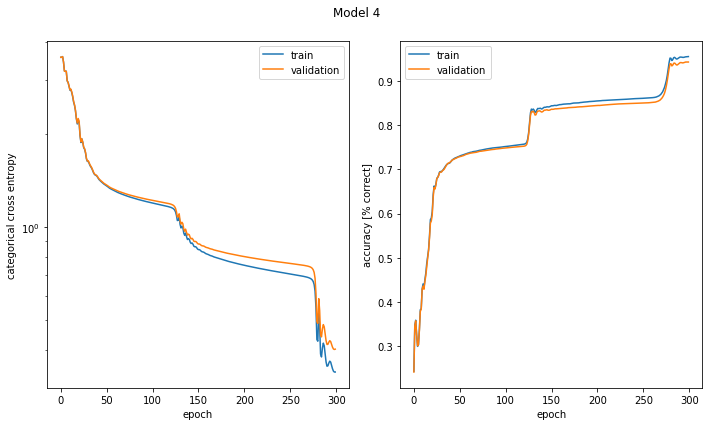

In [43]:
plot_report(train4, title="Model 4")

In [44]:
test4

(tensor(0.9469), 0.3771127760410309, tensor([ 7,  2,  1,  ...,  4,  5,  6]))

In [45]:
model5, train5 = default_net(train_input, train_target, num_of_hidden_layers=1, loss='mse', num_of_neurons=(784, 200, 10), activation='relu', lr=0.01, momentum_coef=0.9, weight_decay=0.2, p_dropout=0.0, num_of_epochs=100, val_split=0.5, verbose=0)
test5 = model5.evaluate(test_input, test_target, return_pred=True)

Added Module Name: 0_Linear 
Added Module Name: 1_ReLU 
Added Module Name: 2_Dropout 
Added Module Name: 3_Linear 
Added Module Name: 4_ReLU 
x_train.shape: torch.Size([30000, 784]) -- y_train.shape: torch.Size([30000, 10])
x_val.shape: torch.Size([30000, 784]) -- y_val.shape: torch.Size([30000, 10])


  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

key: train_loss -- value: 1.0359642505645752
key: train_acc -- value: 0.10890000313520432
key: val_loss -- value: 1.0375601053237915
key: val_acc -- value: 0.10693333297967911


  1%|▊                                                                                 | 1/100 [00:00<01:36,  1.03it/s]

key: train_loss -- value: 0.9977056384086609
key: train_acc -- value: 0.14303334057331085
key: val_loss -- value: 0.9971862435340881
key: val_acc -- value: 0.14303334057331085


  2%|█▋                                                                                | 2/100 [00:01<01:34,  1.04it/s]

key: train_loss -- value: 0.9785043597221375
key: train_acc -- value: 0.17069999873638153
key: val_loss -- value: 0.9766491651535034
key: val_acc -- value: 0.17456667125225067


  3%|██▍                                                                               | 3/100 [00:02<01:31,  1.06it/s]

key: train_loss -- value: 0.9582115411758423
key: train_acc -- value: 0.19103333353996277
key: val_loss -- value: 0.9557729959487915
key: val_acc -- value: 0.19286666810512543


  4%|███▎                                                                              | 4/100 [00:03<01:30,  1.07it/s]

key: train_loss -- value: 0.9415607452392578
key: train_acc -- value: 0.2066333293914795
key: val_loss -- value: 0.9389422535896301
key: val_acc -- value: 0.20890000462532043


  5%|████                                                                              | 5/100 [00:04<01:28,  1.07it/s]

key: train_loss -- value: 0.9295894503593445
key: train_acc -- value: 0.21683333814144135
key: val_loss -- value: 0.926908552646637
key: val_acc -- value: 0.2190999984741211


  6%|████▉                                                                             | 6/100 [00:05<01:26,  1.09it/s]

key: train_loss -- value: 0.918292760848999
key: train_acc -- value: 0.21556666493415833
key: val_loss -- value: 0.9155144095420837
key: val_acc -- value: 0.21683333814144135


  7%|█████▋                                                                            | 7/100 [00:06<01:25,  1.09it/s]

key: train_loss -- value: 0.9068496823310852
key: train_acc -- value: 0.20829999446868896
key: val_loss -- value: 0.9039996266365051
key: val_acc -- value: 0.21026666462421417


  8%|██████▌                                                                           | 8/100 [00:07<01:23,  1.10it/s]

key: train_loss -- value: 0.8994810581207275
key: train_acc -- value: 0.20376667380332947
key: val_loss -- value: 0.8966119885444641
key: val_acc -- value: 0.20703333616256714


  9%|███████▍                                                                          | 9/100 [00:08<01:22,  1.10it/s]

key: train_loss -- value: 0.892004668712616
key: train_acc -- value: 0.20810000598430634
key: val_loss -- value: 0.8893546462059021
key: val_acc -- value: 0.21146667003631592


 10%|████████                                                                         | 10/100 [00:09<01:21,  1.10it/s]

key: train_loss -- value: 0.8848710656166077
key: train_acc -- value: 0.22166666388511658
key: val_loss -- value: 0.8826385140419006
key: val_acc -- value: 0.2248000055551529


 11%|████████▉                                                                        | 11/100 [00:09<01:20,  1.11it/s]

key: train_loss -- value: 0.8811520338058472
key: train_acc -- value: 0.23786666989326477
key: val_loss -- value: 0.8792096376419067
key: val_acc -- value: 0.2402999997138977


 12%|█████████▋                                                                       | 12/100 [00:10<01:19,  1.11it/s]

key: train_loss -- value: 0.8770418167114258
key: train_acc -- value: 0.24770000576972961
key: val_loss -- value: 0.8751434683799744
key: val_acc -- value: 0.2504666745662689


 13%|██████████▌                                                                      | 13/100 [00:11<01:18,  1.11it/s]

key: train_loss -- value: 0.8713731169700623
key: train_acc -- value: 0.2517666518688202
key: val_loss -- value: 0.8692144155502319
key: val_acc -- value: 0.2543666660785675


 14%|███████████▎                                                                     | 14/100 [00:12<01:17,  1.10it/s]

key: train_loss -- value: 0.867275595664978
key: train_acc -- value: 0.25130000710487366
key: val_loss -- value: 0.8648576736450195
key: val_acc -- value: 0.25440001487731934


 15%|████████████▏                                                                    | 15/100 [00:13<01:16,  1.11it/s]

key: train_loss -- value: 0.8653146028518677
key: train_acc -- value: 0.2545333206653595
key: val_loss -- value: 0.862622857093811
key: val_acc -- value: 0.25723332166671753


 16%|████████████▉                                                                    | 16/100 [00:14<01:15,  1.11it/s]

key: train_loss -- value: 0.8601835370063782
key: train_acc -- value: 0.266400009393692
key: val_loss -- value: 0.8573598265647888
key: val_acc -- value: 0.2701333463191986


 17%|█████████████▊                                                                   | 17/100 [00:15<01:14,  1.11it/s]

key: train_loss -- value: 0.8532660603523254
key: train_acc -- value: 0.28376665711402893
key: val_loss -- value: 0.8505386710166931
key: val_acc -- value: 0.28786665201187134


 18%|██████████████▌                                                                  | 18/100 [00:16<01:13,  1.11it/s]

key: train_loss -- value: 0.845592737197876
key: train_acc -- value: 0.29943332076072693
key: val_loss -- value: 0.8428391218185425
key: val_acc -- value: 0.30406665802001953


 19%|███████████████▍                                                                 | 19/100 [00:17<01:12,  1.11it/s]

key: train_loss -- value: 0.8361586332321167
key: train_acc -- value: 0.31646665930747986
key: val_loss -- value: 0.8330685496330261
key: val_acc -- value: 0.32089999318122864


 20%|████████████████▏                                                                | 20/100 [00:17<01:11,  1.11it/s]

key: train_loss -- value: 0.8302688002586365
key: train_acc -- value: 0.3319999873638153
key: val_loss -- value: 0.8265747427940369
key: val_acc -- value: 0.33516666293144226


 21%|█████████████████                                                                | 21/100 [00:18<01:10,  1.11it/s]

key: train_loss -- value: 0.8372669816017151
key: train_acc -- value: 0.333133339881897
key: val_loss -- value: 0.8328540325164795
key: val_acc -- value: 0.3362666666507721


 22%|█████████████████▊                                                               | 22/100 [00:19<01:10,  1.11it/s]

key: train_loss -- value: 0.8306424617767334
key: train_acc -- value: 0.3365333378314972
key: val_loss -- value: 0.8263477087020874
key: val_acc -- value: 0.34060001373291016


 23%|██████████████████▋                                                              | 23/100 [00:20<01:09,  1.10it/s]

key: train_loss -- value: 0.8170655965805054
key: train_acc -- value: 0.3405666649341583
key: val_loss -- value: 0.8133828043937683
key: val_acc -- value: 0.3434000015258789


 24%|███████████████████▍                                                             | 24/100 [00:21<01:09,  1.10it/s]

key: train_loss -- value: 0.8158392310142517
key: train_acc -- value: 0.33570000529289246
key: val_loss -- value: 0.8126604557037354
key: val_acc -- value: 0.3392333388328552


 25%|████████████████████▎                                                            | 25/100 [00:22<01:08,  1.10it/s]

key: train_loss -- value: 0.8157681226730347
key: train_acc -- value: 0.3352000117301941
key: val_loss -- value: 0.8127330541610718
key: val_acc -- value: 0.3380333185195923


 26%|█████████████████████                                                            | 26/100 [00:23<01:07,  1.09it/s]

key: train_loss -- value: 0.8097862601280212
key: train_acc -- value: 0.34066668152809143
key: val_loss -- value: 0.8067880272865295
key: val_acc -- value: 0.34476667642593384


 27%|█████████████████████▊                                                           | 27/100 [00:24<01:06,  1.09it/s]

key: train_loss -- value: 0.798854410648346
key: train_acc -- value: 0.3522999882698059
key: val_loss -- value: 0.7957486510276794
key: val_acc -- value: 0.3562333285808563


 28%|██████████████████████▋                                                          | 28/100 [00:25<01:05,  1.09it/s]

key: train_loss -- value: 0.7963839769363403
key: train_acc -- value: 0.3571999967098236
key: val_loss -- value: 0.7929666638374329
key: val_acc -- value: 0.36026665568351746


 29%|███████████████████████▍                                                         | 29/100 [00:26<01:04,  1.10it/s]

key: train_loss -- value: 0.7989113330841064
key: train_acc -- value: 0.35813334584236145
key: val_loss -- value: 0.7955372929573059
key: val_acc -- value: 0.36169999837875366


 30%|████████████████████████▎                                                        | 30/100 [00:27<01:04,  1.09it/s]

key: train_loss -- value: 0.788377046585083
key: train_acc -- value: 0.36266666650772095
key: val_loss -- value: 0.7854486107826233
key: val_acc -- value: 0.36606666445732117


 31%|█████████████████████████                                                        | 31/100 [00:28<01:03,  1.09it/s]

key: train_loss -- value: 0.7866085767745972
key: train_acc -- value: 0.36340001225471497
key: val_loss -- value: 0.7841921448707581
key: val_acc -- value: 0.3672666549682617


 32%|█████████████████████████▉                                                       | 32/100 [00:29<01:02,  1.09it/s]

key: train_loss -- value: 0.786881148815155
key: train_acc -- value: 0.3657666742801666
key: val_loss -- value: 0.7848162651062012
key: val_acc -- value: 0.3688333332538605


 33%|██████████████████████████▋                                                      | 33/100 [00:30<01:01,  1.08it/s]

key: train_loss -- value: 0.7798107862472534
key: train_acc -- value: 0.37406668066978455
key: val_loss -- value: 0.7779970169067383
key: val_acc -- value: 0.37816667556762695


 34%|███████████████████████████▌                                                     | 34/100 [00:31<01:01,  1.08it/s]

key: train_loss -- value: 0.7678328156471252
key: train_acc -- value: 0.38973334431648254
key: val_loss -- value: 0.7659122943878174
key: val_acc -- value: 0.3937999904155731


 35%|████████████████████████████▎                                                    | 35/100 [00:32<01:00,  1.08it/s]

key: train_loss -- value: 0.751369297504425
key: train_acc -- value: 0.41146665811538696
key: val_loss -- value: 0.7490797638893127
key: val_acc -- value: 0.4151333272457123


 36%|█████████████████████████████▏                                                   | 36/100 [00:33<00:59,  1.08it/s]

key: train_loss -- value: 0.7420010566711426
key: train_acc -- value: 0.42829999327659607
key: val_loss -- value: 0.7385056614875793
key: val_acc -- value: 0.43380001187324524


 37%|█████████████████████████████▉                                                   | 37/100 [00:34<00:58,  1.07it/s]

key: train_loss -- value: 0.763637900352478
key: train_acc -- value: 0.42403334379196167
key: val_loss -- value: 0.7603225708007812
key: val_acc -- value: 0.42776668071746826


 38%|██████████████████████████████▊                                                  | 38/100 [00:35<00:58,  1.07it/s]

key: train_loss -- value: 0.7307461500167847
key: train_acc -- value: 0.43016666173934937
key: val_loss -- value: 0.7279545664787292
key: val_acc -- value: 0.4359000027179718


 39%|███████████████████████████████▌                                                 | 39/100 [00:36<00:57,  1.07it/s]

key: train_loss -- value: 0.7393118739128113
key: train_acc -- value: 0.41936665773391724
key: val_loss -- value: 0.7376636862754822
key: val_acc -- value: 0.42293334007263184


 40%|████████████████████████████████▍                                                | 40/100 [00:37<00:56,  1.06it/s]

key: train_loss -- value: 0.7431631684303284
key: train_acc -- value: 0.41290000081062317
key: val_loss -- value: 0.7418287992477417
key: val_acc -- value: 0.41583332419395447


 41%|█████████████████████████████████▏                                               | 41/100 [00:38<00:55,  1.06it/s]

key: train_loss -- value: 0.7371391654014587
key: train_acc -- value: 0.41636666655540466
key: val_loss -- value: 0.7356379628181458
key: val_acc -- value: 0.420933336019516


 42%|██████████████████████████████████                                               | 42/100 [00:39<00:54,  1.06it/s]

key: train_loss -- value: 0.7250135540962219
key: train_acc -- value: 0.42793333530426025
key: val_loss -- value: 0.722895622253418
key: val_acc -- value: 0.43320000171661377


 43%|██████████████████████████████████▊                                              | 43/100 [00:40<00:53,  1.06it/s]

key: train_loss -- value: 0.7205306887626648
key: train_acc -- value: 0.43736666440963745
key: val_loss -- value: 0.7178303599357605
key: val_acc -- value: 0.4413333237171173


 44%|███████████████████████████████████▋                                             | 44/100 [00:41<00:52,  1.06it/s]

key: train_loss -- value: 0.730014979839325
key: train_acc -- value: 0.4371333420276642
key: val_loss -- value: 0.7273720502853394
key: val_acc -- value: 0.4399999976158142


 45%|████████████████████████████████████▍                                            | 45/100 [00:42<00:52,  1.06it/s]

key: train_loss -- value: 0.7167370915412903
key: train_acc -- value: 0.4401666522026062
key: val_loss -- value: 0.7143442630767822
key: val_acc -- value: 0.4434666633605957


 46%|█████████████████████████████████████▎                                           | 46/100 [00:43<00:51,  1.06it/s]

key: train_loss -- value: 0.714207112789154
key: train_acc -- value: 0.436766654253006
key: val_loss -- value: 0.7123435735702515
key: val_acc -- value: 0.4396333396434784


 47%|██████████████████████████████████████                                           | 47/100 [00:44<00:50,  1.05it/s]

key: train_loss -- value: 0.717651903629303
key: train_acc -- value: 0.4327666759490967
key: val_loss -- value: 0.7162169218063354
key: val_acc -- value: 0.43673333525657654


 48%|██████████████████████████████████████▉                                          | 48/100 [00:45<00:49,  1.05it/s]

key: train_loss -- value: 0.7151787281036377
key: train_acc -- value: 0.43566668033599854
key: val_loss -- value: 0.7137728333473206
key: val_acc -- value: 0.4406000077724457


 49%|███████████████████████████████████████▋                                         | 49/100 [00:46<00:48,  1.05it/s]

key: train_loss -- value: 0.7072671055793762
key: train_acc -- value: 0.44546666741371155
key: val_loss -- value: 0.7056033611297607
key: val_acc -- value: 0.4503999948501587


 50%|████████████████████████████████████████▌                                        | 50/100 [00:47<00:47,  1.05it/s]

key: train_loss -- value: 0.701729416847229
key: train_acc -- value: 0.4572666585445404
key: val_loss -- value: 0.6997703909873962
key: val_acc -- value: 0.4621666669845581


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:48<00:46,  1.05it/s]

key: train_loss -- value: 0.7010502815246582
key: train_acc -- value: 0.4677000045776367
key: val_loss -- value: 0.6988344192504883
key: val_acc -- value: 0.4729999899864197


 52%|██████████████████████████████████████████                                       | 52/100 [00:49<00:45,  1.05it/s]

key: train_loss -- value: 0.6883829832077026
key: train_acc -- value: 0.48606666922569275
key: val_loss -- value: 0.6869440078735352
key: val_acc -- value: 0.4885999858379364


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:50<00:44,  1.05it/s]

key: train_loss -- value: 0.6769025921821594
key: train_acc -- value: 0.5011666417121887
key: val_loss -- value: 0.678778886795044
key: val_acc -- value: 0.49736666679382324


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:51<00:43,  1.05it/s]

key: train_loss -- value: 0.6824295520782471
key: train_acc -- value: 0.49656665325164795
key: val_loss -- value: 0.6870101690292358
key: val_acc -- value: 0.4942333400249481


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:52<00:42,  1.05it/s]

key: train_loss -- value: 0.6692547798156738
key: train_acc -- value: 0.5026000142097473
key: val_loss -- value: 0.673191487789154
key: val_acc -- value: 0.49976667761802673


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:53<00:42,  1.05it/s]

key: train_loss -- value: 0.6543368101119995
key: train_acc -- value: 0.5080999732017517
key: val_loss -- value: 0.6564375162124634
key: val_acc -- value: 0.5074666738510132


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:54<00:41,  1.05it/s]

key: train_loss -- value: 0.6500305533409119
key: train_acc -- value: 0.5107666850090027
key: val_loss -- value: 0.6513330936431885
key: val_acc -- value: 0.5110333561897278


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:55<00:40,  1.05it/s]

key: train_loss -- value: 0.6471295356750488
key: train_acc -- value: 0.5146333575248718
key: val_loss -- value: 0.6485043168067932
key: val_acc -- value: 0.51419997215271


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:56<00:39,  1.05it/s]

key: train_loss -- value: 0.6376084089279175
key: train_acc -- value: 0.5203999876976013
key: val_loss -- value: 0.6397219896316528
key: val_acc -- value: 0.5198000073432922


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:57<00:38,  1.04it/s]

key: train_loss -- value: 0.631600558757782
key: train_acc -- value: 0.5213666558265686
key: val_loss -- value: 0.634705126285553
key: val_acc -- value: 0.5213666558265686


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:58<00:37,  1.05it/s]

key: train_loss -- value: 0.633216142654419
key: train_acc -- value: 0.519266664981842
key: val_loss -- value: 0.6367079615592957
key: val_acc -- value: 0.5184999704360962


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:59<00:36,  1.04it/s]

key: train_loss -- value: 0.630418062210083
key: train_acc -- value: 0.5199666619300842
key: val_loss -- value: 0.6335957050323486
key: val_acc -- value: 0.5197333097457886


 63%|███████████████████████████████████████████████████                              | 63/100 [01:00<00:35,  1.04it/s]

key: train_loss -- value: 0.6242385506629944
key: train_acc -- value: 0.522433340549469
key: val_loss -- value: 0.6268798112869263
key: val_acc -- value: 0.5228999853134155


 64%|███████████████████████████████████████████████████▊                             | 64/100 [01:01<00:34,  1.04it/s]

key: train_loss -- value: 0.6228894591331482
key: train_acc -- value: 0.522766649723053
key: val_loss -- value: 0.6251164078712463
key: val_acc -- value: 0.5251333117485046


 65%|████████████████████████████████████████████████████▋                            | 65/100 [01:02<00:33,  1.04it/s]

key: train_loss -- value: 0.6237914562225342
key: train_acc -- value: 0.5230333209037781
key: val_loss -- value: 0.6259176135063171
key: val_acc -- value: 0.5256999731063843


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [01:03<00:32,  1.04it/s]

key: train_loss -- value: 0.6213773488998413
key: train_acc -- value: 0.5252333283424377
key: val_loss -- value: 0.6237170696258545
key: val_acc -- value: 0.5278000235557556


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [01:04<00:31,  1.04it/s]

key: train_loss -- value: 0.6189308166503906
key: train_acc -- value: 0.5269333124160767
key: val_loss -- value: 0.6215777397155762
key: val_acc -- value: 0.529366672039032


 68%|███████████████████████████████████████████████████████                          | 68/100 [01:05<00:30,  1.04it/s]

key: train_loss -- value: 0.6180314421653748
key: train_acc -- value: 0.5282333493232727
key: val_loss -- value: 0.6208306550979614
key: val_acc -- value: 0.529533326625824


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [01:06<00:29,  1.04it/s]

key: train_loss -- value: 0.6170859336853027
key: train_acc -- value: 0.5288000106811523
key: val_loss -- value: 0.6198223233222961
key: val_acc -- value: 0.5305666923522949


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [01:07<00:28,  1.04it/s]

key: train_loss -- value: 0.6159189343452454
key: train_acc -- value: 0.5298666954040527
key: val_loss -- value: 0.6184453964233398
key: val_acc -- value: 0.5318666696548462


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [01:08<00:27,  1.04it/s]

key: train_loss -- value: 0.6150317788124084
key: train_acc -- value: 0.5309000015258789
key: val_loss -- value: 0.617378830909729
key: val_acc -- value: 0.53329998254776


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [01:09<00:26,  1.04it/s]

key: train_loss -- value: 0.6134975552558899
key: train_acc -- value: 0.5314000248908997
key: val_loss -- value: 0.6158726811408997
key: val_acc -- value: 0.5337333083152771


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [01:10<00:25,  1.04it/s]

key: train_loss -- value: 0.6116710305213928
key: train_acc -- value: 0.5321333408355713
key: val_loss -- value: 0.6142600774765015
key: val_acc -- value: 0.5347333550453186


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [01:11<00:25,  1.04it/s]

key: train_loss -- value: 0.6111785769462585
key: train_acc -- value: 0.5333333611488342
key: val_loss -- value: 0.6140365600585938
key: val_acc -- value: 0.5353000164031982


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [01:12<00:24,  1.04it/s]

key: train_loss -- value: 0.6106347441673279
key: train_acc -- value: 0.5347333550453186
key: val_loss -- value: 0.6136174201965332
key: val_acc -- value: 0.5360333323478699


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [01:13<00:23,  1.04it/s]

key: train_loss -- value: 0.6089369654655457
key: train_acc -- value: 0.5363666415214539
key: val_loss -- value: 0.6118626594543457
key: val_acc -- value: 0.537933349609375


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [01:14<00:22,  1.04it/s]

key: train_loss -- value: 0.6073736548423767
key: train_acc -- value: 0.5374333262443542
key: val_loss -- value: 0.6101700067520142
key: val_acc -- value: 0.5387333035469055


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [01:15<00:21,  1.04it/s]

key: train_loss -- value: 0.6067685484886169
key: train_acc -- value: 0.5385333299636841
key: val_loss -- value: 0.6094918847084045
key: val_acc -- value: 0.539900004863739


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [01:16<00:20,  1.04it/s]

key: train_loss -- value: 0.6059892177581787
key: train_acc -- value: 0.5392000079154968
key: val_loss -- value: 0.60872882604599
key: val_acc -- value: 0.5407999753952026


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [01:17<00:19,  1.04it/s]

key: train_loss -- value: 0.6047996878623962
key: train_acc -- value: 0.5396999716758728
key: val_loss -- value: 0.6076552867889404
key: val_acc -- value: 0.5409333109855652


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [01:18<00:18,  1.04it/s]

key: train_loss -- value: 0.6037707924842834
key: train_acc -- value: 0.5404999852180481
key: val_loss -- value: 0.6067525148391724
key: val_acc -- value: 0.5414000153541565


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [01:19<00:17,  1.04it/s]

key: train_loss -- value: 0.6028045415878296
key: train_acc -- value: 0.5415666699409485
key: val_loss -- value: 0.60582435131073
key: val_acc -- value: 0.5425666570663452


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [01:20<00:16,  1.04it/s]

key: train_loss -- value: 0.601935625076294
key: train_acc -- value: 0.5425000190734863
key: val_loss -- value: 0.6048960089683533
key: val_acc -- value: 0.5433666706085205


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [01:21<00:15,  1.04it/s]

key: train_loss -- value: 0.6012997627258301
key: train_acc -- value: 0.5434666872024536
key: val_loss -- value: 0.6041812896728516
key: val_acc -- value: 0.5447333455085754


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [01:22<00:14,  1.04it/s]

key: train_loss -- value: 0.6004568934440613
key: train_acc -- value: 0.5440999865531921
key: val_loss -- value: 0.6033132076263428
key: val_acc -- value: 0.545199990272522


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [01:23<00:13,  1.03it/s]

key: train_loss -- value: 0.5993821620941162
key: train_acc -- value: 0.5442666411399841
key: val_loss -- value: 0.6022653579711914
key: val_acc -- value: 0.5454999804496765


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [01:24<00:12,  1.03it/s]

key: train_loss -- value: 0.598676323890686
key: train_acc -- value: 0.5440333485603333
key: val_loss -- value: 0.601612389087677
key: val_acc -- value: 0.5458333492279053


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [01:25<00:11,  1.03it/s]

key: train_loss -- value: 0.5981744527816772
key: train_acc -- value: 0.5442333221435547
key: val_loss -- value: 0.6011335849761963
key: val_acc -- value: 0.5460666418075562


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [01:26<00:10,  1.03it/s]

key: train_loss -- value: 0.5973879098892212
key: train_acc -- value: 0.5447999835014343
key: val_loss -- value: 0.6003270745277405
key: val_acc -- value: 0.5465999841690063


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [01:27<00:09,  1.03it/s]

key: train_loss -- value: 0.5965447425842285
key: train_acc -- value: 0.5454333424568176
key: val_loss -- value: 0.5994328260421753
key: val_acc -- value: 0.5476333498954773


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [01:28<00:08,  1.03it/s]

key: train_loss -- value: 0.5959436297416687
key: train_acc -- value: 0.5458666682243347
key: val_loss -- value: 0.5987817049026489
key: val_acc -- value: 0.5479666590690613


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [01:29<00:07,  1.03it/s]

key: train_loss -- value: 0.5953670144081116
key: train_acc -- value: 0.5462666749954224
key: val_loss -- value: 0.5981902480125427
key: val_acc -- value: 0.5482000112533569


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [01:30<00:06,  1.03it/s]

key: train_loss -- value: 0.5947393774986267
key: train_acc -- value: 0.5463666915893555
key: val_loss -- value: 0.5975831747055054
key: val_acc -- value: 0.5487666726112366


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [01:31<00:05,  1.03it/s]

key: train_loss -- value: 0.5941477417945862
key: train_acc -- value: 0.5465999841690063
key: val_loss -- value: 0.5970108509063721
key: val_acc -- value: 0.5487333536148071


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [01:32<00:04,  1.03it/s]

key: train_loss -- value: 0.5935306549072266
key: train_acc -- value: 0.5464666485786438
key: val_loss -- value: 0.5963916778564453
key: val_acc -- value: 0.5491666793823242


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [01:33<00:03,  1.03it/s]

key: train_loss -- value: 0.5929399132728577
key: train_acc -- value: 0.546833336353302
key: val_loss -- value: 0.5957841873168945
key: val_acc -- value: 0.5492333173751831


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [01:34<00:02,  1.03it/s]

key: train_loss -- value: 0.5924628376960754
key: train_acc -- value: 0.5472999811172485
key: val_loss -- value: 0.5952838063240051
key: val_acc -- value: 0.5493666529655457


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [01:35<00:01,  1.03it/s]

key: train_loss -- value: 0.5919522047042847
key: train_acc -- value: 0.5474333167076111
key: val_loss -- value: 0.5947709679603577
key: val_acc -- value: 0.5497999787330627


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [01:36<00:00,  1.03it/s]

key: train_loss -- value: 0.5913577079772949
key: train_acc -- value: 0.5480333566665649
key: val_loss -- value: 0.5941861867904663
key: val_acc -- value: 0.5501333475112915


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:36<00:00,  1.03it/s]


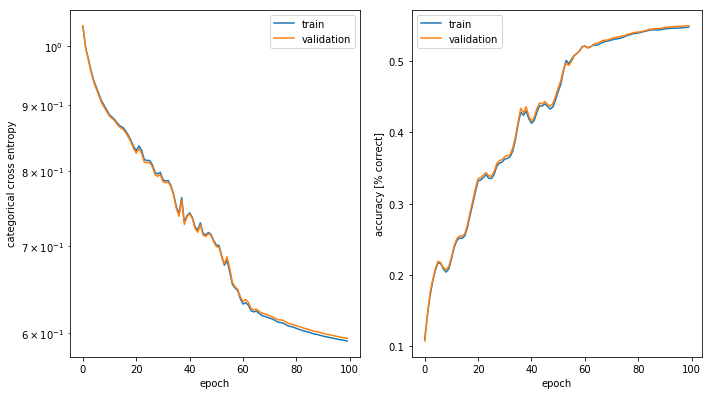

In [46]:
plot_report(train5)

In [47]:
test5

(tensor(0.5511), 0.5875523090362549, tensor([ 0,  5,  1,  ...,  4,  5,  0]))